# Trackster validation on electron data (1 ≤ e- ≤ 5)

## Introduction

This script validates the tracksters reconstructed by both the TICL algorithm (TICL tracksters) and our ML algorithm (model tracksters) against the caloparticles generated by the simulation. These tracksters are built from layer clusters that are produced by the CLUE2D algorithm. The following metrics are considered:
* Efficiency:

$$ \frac{\text{Total number of caloparticles that have been associated to at least one trackster}}{\text{Total number of caloparticles}} 
$$
<br>

<div style="text-align: center;">
${\scriptsize \text{A caloparticle associated to a trackster has a shared energy > 50% (of the caloparticle's raw energy after applying correction of removing one hit LCs) with the trackster.} }$  
</div>




* Purity

$$ \frac{\text{Total number of tracksters that have been associated to at least one caloparticle}}{\text{Total number of tracksters}} 
$$
<br>
<div style="text-align: center;">
${\scriptsize \text{A trackster associated to a caloparticle has a reco_to_sim score < 0.2 with it.}}$
</div>

* Number tracksters ratio:

$$ \frac{\text{Total number of tracksters}}{\text{Total number of caloparticles}}$$



## Definition of Ground Truth
* SimtrackstersCP tree but with LCs that have noh = 1 removed.
* Perfect pattern recognition reconstructs subset of SimtrackstersCP shower that has LCs with noh > 1, since both TICL and our model was trained to reconstruct the shower partially.


## Modules to import
* model.py
* test.py
* train.py
* Imports.py

## Code

## Section 1: Making predictions on test data with ML model and calculating metrics

In [3]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from test import CCV2
from ground_truth import CCV3
from train import CCV1
from torch_geometric.data import DataLoader 
from model import Net
#from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from Imports import Aggloremative, calculate_reco_to_sim_score_and_sharedE, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
#1: Load Data + Model
#1.1: Load Data

testpath = "/vols/cms/mm1221/Data/100k/5e/test/"  
data_test = CCV3(testpath, max_events=99)
gt_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])

# Define ground truth and trackster data
GT_ind = data_test.stsCP_vertices_indexes
GT_mult = data_test.stsCP_vertices_multiplicity
GT_bc_x = data_test.stsCP_barycenter_x
GT_regressed_energy = data_test.stsCP_regressed_energy
energies = data_test.all_vertices_energy

Track_ind = data_test.ts_vertices_indexes
Track_mult = data_test.ts_vertices_multiplicity


#1.2: Load Model

model = Net(hidden_dim=128, num_layers=5, dropout=0.3, contrastive_dim=128, k=48)
checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/LC/NegativeMining/runs3e/hd128nl5cd128k48T5/epoch-20.pt',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model'])  
model.eval()  

### Loading data


  0%|                                                                                             | 0/1 [00:03<?, ?it/s]

Reached 99!



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0-4): 5 x DynamicEdgeConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    ), k=48)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=128, bias=True)
  )
)

## Intermission: Cosine similarity plots

After loading the fully trained model, we run the training data through another, final forward pass on the model as though we were continuing to train (but without then computing the loss and backpropagating). The cosine similarity of the embeddings, generated by the model, that form negative pairs can then be plotted.

In [5]:
import torch.nn.functional as F

train_path = "/vols/cms/mm1221/Data/100k/5e/train/"  
data_train = CCV1(train_path, max_events=99)
train_loader = DataLoader(data_train, batch_size=1, shuffle=False, follow_batch=['x','lc_ne'])

### Loading data


  0%|                                                                                             | 0/3 [00:21<?, ?it/s]

Reached 99!


In [13]:
CP_x = data_train.stsCP_vertices_x
CP_y = data_train.stsCP_vertices_y
CP_z = data_train.stsCP_vertices_z
CP_ind = data_train.stsCP_vertices_indexes
CP_energy = data_train.stsCP_vertices_energy

tTrack_x = data_train.ts_vertices_x
tTrack_y = data_train.ts_vertices_y
tTrack_z = data_train.ts_vertices_z
tTrack_ind = data_train.ts_vertices_indexes
tTrack_energy = data_train.ts_vertices_energy # t for train

tenergies = data_train.all_vertices_energy
tlayerid = data_train.all_vertices_layer_id
tnoh = data_train.all_vertices_noh
teta = data_train.all_vertices_eta
tphi = data_train.all_vertices_phi
t_x = data_train.all_vertices_x
t_y = data_train.all_vertices_y
t_z = data_train.all_vertices_z
ttime = data_train.all_vertices_time
ttype = data_train.all_vertices_type

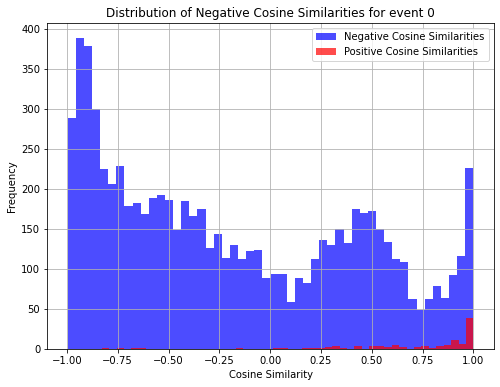

In [7]:
for data in train_loader:
    out = model(data.x, data.x_batch)
    values_edges, counts_edges = np.unique(data.lc_ne_batch.detach().cpu().numpy(), return_counts=True)
    values, counts = np.unique(data.x_batch.detach().cpu().numpy(), return_counts=True)
    losses = []
    for e in range(len(counts)):
        lower_edge_e = 0 if e == 0 else np.sum(counts_edges[:e])
        upper_edge_e = lower_edge_e + counts_edges[e]

        lower_edge_o = 0 if e == 0 else np.sum(counts[:e]) 
        upper_edge_o = lower_edge_o + counts[e]
        
        start_pos = out[0][lower_edge_o:upper_edge_o][data.x_pe[lower_edge_o:upper_edge_o, 0]]
        end_pos = out[0][lower_edge_o:upper_edge_o][data.x_pe[lower_edge_o:upper_edge_o, 1]]
        start_neg = out[0][lower_edge_o:upper_edge_o][data.x_ne[lower_edge_e:upper_edge_e, 0]]
        end_neg = out[0][lower_edge_o:upper_edge_o][data.x_ne[lower_edge_e:upper_edge_e, 1]]
        lc_ne = data.lc_ne[lower_edge_e:upper_edge_e]
        break
    break
 
        
def compute_cosine_similarity(start_pos, end_pos, start_neg, end_neg, lc_ne, temperature=0.05):
    xdevice = start_pos.get_device()
    z_start_pos = F.normalize(start_pos, dim=1)
    z_end_pos = F.normalize(end_pos, dim=1)
    z_start_neg = F.normalize(start_neg, dim=1)
    z_end_neg = F.normalize(end_neg, dim=1)
    positives = torch.exp(F.cosine_similarity(z_start_pos,z_end_pos))
    positives_similarities = F.cosine_similarity(z_start_pos,z_end_pos)
    
    # generate hard negatives
    values, counts = np.unique(lc_ne, return_counts=True)
    hard_neg_edges = []
    all_neg_similarities = []
    
    for lc in range(0,len(counts)):
        lower_edge = 0 if lc == 0 else np.sum(counts[:lc])
        upper_edge = lower_edge + counts[lc]
        negatives_lc = F.cosine_similarity(z_start_neg[lower_edge:upper_edge],z_end_neg[lower_edge:upper_edge])
        #print(len(negatives_lc)) #<-- is the number of negative edges created for a given lc reasonable?
        
        # Store all the similarities for the current negative set
        all_neg_similarities.extend(negatives_lc.detach().cpu().numpy())  # Convert to numpy for easier plotting
        
        
    
    plt.figure(figsize=(8, 6))
    plt.hist(all_neg_similarities, bins=50, color='blue', alpha=0.7, label='Negative Cosine Similarities')
    plt.hist(positives_similarities.detach().cpu().numpy(), bins=50, color='red', alpha=0.7, label='Positive Cosine Similarities')
    #plt.hist(positives_similarities.detach().cpu().numpy(), bins=50, color='blue', alpha=0.7)
    plt.title('Distribution of Negative Cosine Similarities for event 0')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

loss = compute_cosine_similarity(start_pos, end_pos, start_neg, end_neg, lc_ne, temperature=0.1)


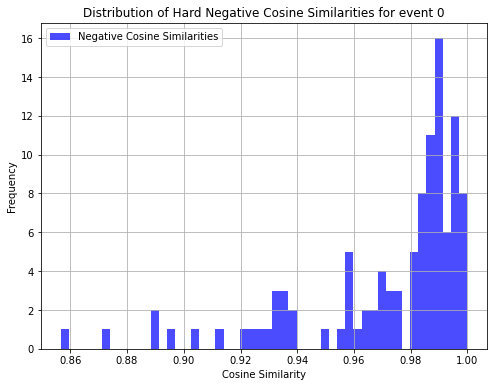

In [8]:
for data in train_loader:
    out = model(data.x, data.x_batch)
    values_edges, counts_edges = np.unique(data.lc_ne_batch.detach().cpu().numpy(), return_counts=True)
    values, counts = np.unique(data.x_batch.detach().cpu().numpy(), return_counts=True)
    losses = []
    for e in range(len(counts)):
        lower_edge_e = 0 if e == 0 else np.sum(counts_edges[:e])
        upper_edge_e = lower_edge_e + counts_edges[e]

        lower_edge_o = 0 if e == 0 else np.sum(counts[:e]) 
        upper_edge_o = lower_edge_o + counts[e]
        
        start_pos = out[0][lower_edge_o:upper_edge_o][data.x_pe[lower_edge_o:upper_edge_o, 0]]
        end_pos = out[0][lower_edge_o:upper_edge_o][data.x_pe[lower_edge_o:upper_edge_o, 1]]
        start_neg = out[0][lower_edge_o:upper_edge_o][data.x_ne[lower_edge_e:upper_edge_e, 0]]
        end_neg = out[0][lower_edge_o:upper_edge_o][data.x_ne[lower_edge_e:upper_edge_e, 1]]
        lc_ne = data.lc_ne[lower_edge_e:upper_edge_e]
        neg_edge_indices = data.x_ne[lower_edge_e:upper_edge_e]
        break
    break
 
        
def compute_cosine_similarity(start_pos, end_pos, start_neg, end_neg, neg_edge_indices, lc_ne, temperature=0.05):
    xdevice = start_pos.get_device()
    z_start_pos = F.normalize(start_pos, dim=1)
    z_end_pos = F.normalize(end_pos, dim=1)
    z_start_neg = F.normalize(start_neg, dim=1)
    z_end_neg = F.normalize(end_neg, dim=1)
    positives = torch.exp(F.cosine_similarity(z_start_pos,z_end_pos))
    positives_similarities = F.cosine_similarity(z_start_pos,z_end_pos)
    
    # generate hard negatives
    values, counts = np.unique(lc_ne, return_counts=True)
    hard_neg_similarity = []
    hard_neg_edge_indices = []
    all_neg_similarities = []
    
    i=0
    for lc in range(0,len(counts)):
        lower_edge = 0 if lc == 0 else np.sum(counts[:lc])
        upper_edge = lower_edge + counts[lc]
        negatives_lc = F.cosine_similarity(z_start_neg[lower_edge:upper_edge],z_end_neg[lower_edge:upper_edge])
        neg_edge_indices_lc = neg_edge_indices[lower_edge:upper_edge]
        
        hard_neg_edge_idx = torch.argmax(negatives_lc)
        hard_neg_similarity.append(negatives_lc[hard_neg_edge_idx].detach().cpu().numpy())
        hard_neg_edge_indices.append(neg_edge_indices_lc[hard_neg_edge_idx])
        #print(neg_edge_indices_lc[hard_neg_edge_idx][0].detach().cpu().numpy() == lc) # should be true every time!

        all_neg_similarities.extend(negatives_lc.detach().cpu().numpy())  # Convert to numpy for easier plotting

    
    plt.figure(figsize=(8, 6))
    plt.hist(hard_neg_similarity, bins=50, color='blue', alpha=0.7, label='Negative Cosine Similarities')
    #plt.hist(positives_similarities.detach().cpu().numpy(), bins=50, color='red', alpha=0.7, label='Positive Cosine Similarities')
    plt.title('Distribution of Hard Negative Cosine Similarities for event 0')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

loss = compute_cosine_similarity(start_pos, end_pos, start_neg, end_neg, neg_edge_indices, lc_ne, temperature=0.1)

Do across multiple events

#### Understanding the nature of hard negatives

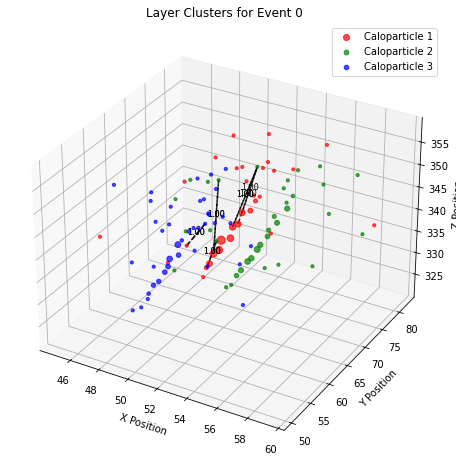

[(0.9958129525184631, (2, 48)), (0.9958129525184631, (48, 2)), (0.9988815784454346, (5, 56)), (0.9976240396499634, (29, 88)), (0.9976240396499634, (88, 29)), (0.9998665452003479, (95, 55)), (0.9997424483299255, (4, 56)), (0.9988536238670349, (7, 56)), (0.9997424483299255, (56, 4)), (0.9998665452003479, (55, 95))]


In [9]:
import heapq
from mpl_toolkits.mplot3d import Axes3D

for data in train_loader:
    out = model(data.x, data.x_batch)
    values_edges, counts_edges = np.unique(data.lc_ne_batch.detach().cpu().numpy(), return_counts=True)
    values, counts = np.unique(data.x_batch.detach().cpu().numpy(), return_counts=True)
    losses = []
    for e in range(len(counts)):
        lower_edge_e = 0 if e == 0 else np.sum(counts_edges[:e])
        upper_edge_e = lower_edge_e + counts_edges[e]

        lower_edge_o = 0 if e == 0 else np.sum(counts[:e]) 
        upper_edge_o = lower_edge_o + counts[e]
        
        start_pos = out[0][lower_edge_o:upper_edge_o][data.x_pe[lower_edge_o:upper_edge_o, 0]]
        end_pos = out[0][lower_edge_o:upper_edge_o][data.x_pe[lower_edge_o:upper_edge_o, 1]]
        start_neg = out[0][lower_edge_o:upper_edge_o][data.x_ne[lower_edge_e:upper_edge_e, 0]]
        end_neg = out[0][lower_edge_o:upper_edge_o][data.x_ne[lower_edge_e:upper_edge_e, 1]]
        lc_ne = data.lc_ne[lower_edge_e:upper_edge_e]
        neg_edge_indices = data.x_ne[lower_edge_e:upper_edge_e]
        break
    break
 
        
def visualise_hard_negatives(start_pos, end_pos, start_neg, end_neg, neg_edge_indices, lc_ne):
    xdevice = start_pos.get_device()
    z_start_pos = F.normalize(start_pos, dim=1)
    z_end_pos = F.normalize(end_pos, dim=1)
    z_start_neg = F.normalize(start_neg, dim=1)
    z_end_neg = F.normalize(end_neg, dim=1)
    positives = torch.exp(F.cosine_similarity(z_start_pos,z_end_pos))
    positives_similarities = F.cosine_similarity(z_start_pos,z_end_pos)
    
    #---------------------- generate hard negatives ------------------------------
    values, counts = np.unique(lc_ne, return_counts=True)
    hard_neg_similarity = []
    hard_neg_edge_indices = []
    all_neg_similarities = []
    top_10_hard_neg_edges = []
    
    i=0
    for lc in range(0,len(counts)):
        lower_edge = 0 if lc == 0 else np.sum(counts[:lc])
        upper_edge = lower_edge + counts[lc]
        negatives_lc = F.cosine_similarity(z_start_neg[lower_edge:upper_edge],z_end_neg[lower_edge:upper_edge])
        neg_edge_indices_lc = neg_edge_indices[lower_edge:upper_edge]
        
        # Identify hard negative
        hard_neg_edge_row = torch.argmax(negatives_lc)
        hard_neg_sim = negatives_lc[hard_neg_edge_row].item()  # Convert tensor to scalar
        hard_neg_edge_index = neg_edge_indices_lc[hard_neg_edge_row].cpu().numpy()  # Convert to numpy array
        
        # Store all hard negatives
        hard_neg_similarity.append(hard_neg_sim)
        hard_neg_edge_indices.append(hard_neg_edge_index.tolist())
        #print(neg_edge_indices_lc[hard_neg_edge_idx])
        #print(neg_edge_indices_lc[hard_neg_edge_idx][0].detach().cpu().numpy() == lc) # should be true every time!
        
        # Keep track of the top 5 highest cosine similarity negatives
        heapq.heappush(top_10_hard_neg_edges, (hard_neg_sim, tuple(hard_neg_edge_index)))  # Store edge as tuple
        
        # Ensure only the top 5 remain (pop the smallest similarity if more than 5)
        if len(top_10_hard_neg_edges) > 10:
            heapq.heappop(top_10_hard_neg_edges)

        all_neg_similarities.extend(negatives_lc.detach().cpu().numpy())  # Convert to numpy for easier plotting

        
    #------------------- Plot in 3D detector space ---------------------------------
    # Select Event 0
    event_idx = 0
    x_event = CP_x[event_idx]  # Shape: (num_caloparticles, num_layer_clusters)
    y_event = CP_y[event_idx]
    z_event = CP_z[event_idx]
    energy_event = CP_energy[event_idx]
    
    # Flatten layer cluster arrays for indexing
    flat_x = ak.flatten(x_event)
    flat_y = ak.flatten(y_event)
    flat_z = ak.flatten(z_event)
    flat_energy = ak.flatten(energy_event)

    # Define Colors for Caloparticles
    num_caloparticles = len(x_event)
    colors = ['r', 'g', 'b', 'c', 'm', 'y']  # Extend if more caloparticles exist

    # Enable interactive 3D plots
    #%matplotlib notebook 

    # Create 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Each Caloparticle Separately
    for i in range(num_caloparticles):
        x = x_event[i]
        y = y_event[i]
        z = z_event[i]
        energy = energy_event[i]

        # Scale marker size with energy (adjust factor for better visibility)
        marker_sizes = np.clip(energy * 10, 10, 500)  # Scale and set limits

        # Plot scatter with individual color
        ax.scatter(x, y, z, s=marker_sizes, color=colors[i % len(colors)], alpha=0.7, label=f'Caloparticle {i+1}')
    
    # Add Lines for Top 10 Hard Negative Edges
    for sim, (idx1, idx2) in top_10_hard_neg_edges:  # idx1, idx2 are LC indices in the flattened arrays
        x1, y1, z1 = flat_x[idx1], flat_y[idx1], flat_z[idx1]
        x2, y2, z2 = flat_x[idx2], flat_y[idx2], flat_z[idx2]

        # Draw line between layer cluster pairs forming a hard negative edge
        ax.plot([x1, x2], [y1, y2], [z1, z2], color='black', linestyle='dashed', linewidth=1.5, alpha=0.8)
        
        # Compute midpoint for labeling
        mid_x, mid_y, mid_z = (x1 + x2) / 2, (y1 + y2) / 2, (z1 + z2) / 2

        # Display cosine similarity as a label near the midpoint
        ax.text(mid_x, mid_y, mid_z, f"{sim:.2f}", color='black', fontsize=8, ha='center')



    # Labels & Legend
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title('Layer Clusters for Event 0')
    ax.legend()

    # Show Plot
    plt.show()
    
    """
    #------------------- Distribution of negative cosine similarities ----------------
    plt.figure(figsize=(8, 6))
    plt.hist(all_neg_similarities, bins=50, color='blue', alpha=0.7, label='Negative Cosine Similarities')
    plt.hist(positives_similarities.detach().cpu().numpy(), bins=50, color='red', alpha=0.7, label='Positive Cosine Similarities')
    plt.title('Distribution of Negative Cosine Similarities for event 0')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    
    return top_10_hard_neg_edges

top_10 = visualise_hard_negatives(start_pos, end_pos, start_neg, end_neg, neg_edge_indices, lc_ne)
print(top_10)

#### What LCs are TICL filtering?? - probing the additional LCs that are removed after LCs with noh = 1 are removed.

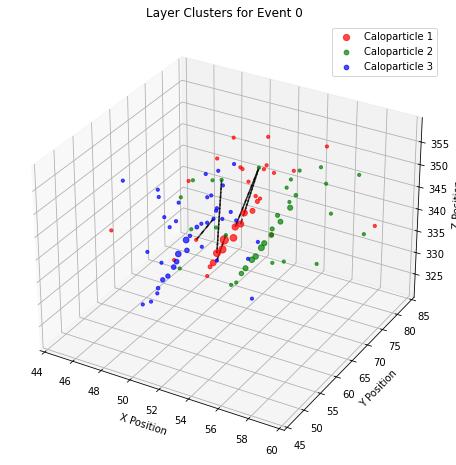

[(0.9958129525184631, (2, 48)), (0.9958129525184631, (48, 2)), (0.9988815784454346, (5, 56)), (0.9976240396499634, (29, 88)), (0.9976240396499634, (88, 29)), (0.9998665452003479, (95, 55)), (0.9997424483299255, (4, 56)), (0.9988536238670349, (7, 56)), (0.9997424483299255, (56, 4)), (0.9998665452003479, (55, 95))]


In [10]:
# simulated -- repeats and noh = 1 removed 

def visualise_hard_negatives(start_pos, end_pos, start_neg, end_neg, neg_edge_indices, lc_ne):
    xdevice = start_pos.get_device()
    z_start_pos = F.normalize(start_pos, dim=1)
    z_end_pos = F.normalize(end_pos, dim=1)
    z_start_neg = F.normalize(start_neg, dim=1)
    z_end_neg = F.normalize(end_neg, dim=1)
    positives = torch.exp(F.cosine_similarity(z_start_pos,z_end_pos))
    positives_similarities = F.cosine_similarity(z_start_pos,z_end_pos)
    
    #---------------------- generate hard negatives ------------------------------
    values, counts = np.unique(lc_ne, return_counts=True)
    hard_neg_similarity = []
    hard_neg_edge_indices = []
    all_neg_similarities = []
    top_10_hard_neg_edges = []
    
    i=0
    for lc in range(0,len(counts)):
        lower_edge = 0 if lc == 0 else np.sum(counts[:lc])
        upper_edge = lower_edge + counts[lc]
        negatives_lc = F.cosine_similarity(z_start_neg[lower_edge:upper_edge],z_end_neg[lower_edge:upper_edge])
        neg_edge_indices_lc = neg_edge_indices[lower_edge:upper_edge]
        
        # Identify hard negative
        hard_neg_edge_row = torch.argmax(negatives_lc)
        hard_neg_sim = negatives_lc[hard_neg_edge_row].item()  # Convert tensor to scalar
        hard_neg_edge_index = neg_edge_indices_lc[hard_neg_edge_row].cpu().numpy()  # Convert to numpy array
        
        # Store all hard negatives
        hard_neg_similarity.append(hard_neg_sim)
        hard_neg_edge_indices.append(hard_neg_edge_index.tolist())
        #print(neg_edge_indices_lc[hard_neg_edge_idx])
        #print(neg_edge_indices_lc[hard_neg_edge_idx][0].detach().cpu().numpy() == lc) # should be true every time!
        
        # Keep track of the top 5 highest cosine similarity negatives
        heapq.heappush(top_10_hard_neg_edges, (hard_neg_sim, tuple(hard_neg_edge_index)))  # Store edge as tuple
        
        # Ensure only the top 5 remain (pop the smallest similarity if more than 5)
        if len(top_10_hard_neg_edges) > 10:
            heapq.heappop(top_10_hard_neg_edges)

        all_neg_similarities.extend(negatives_lc.detach().cpu().numpy())  # Convert to numpy for easier plotting

        
    #------------------- Plot in 3D detector space ---------------------------------
    # Select Event 0
    event_idx = 0
    x_event = CP_x[event_idx]  # Shape: (num_caloparticles, num_layer_clusters)
    y_event = CP_y[event_idx]
    z_event = CP_z[event_idx]
    energy_event = CP_energy[event_idx]
    
    # Flatten layer cluster arrays for indexing
    flat_x = ak.flatten(x_event)
    flat_y = ak.flatten(y_event)
    flat_z = ak.flatten(z_event)
    flat_energy = ak.flatten(energy_event)

    # Define Colors for Caloparticles
    num_caloparticles = len(x_event)
    colors = ['r', 'g', 'b', 'c', 'm', 'y']  # Extend if more caloparticles exist

    # Enable interactive 3D plots
    #%matplotlib notebook 

    # Create 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Each Caloparticle Separately
    for i in range(num_caloparticles):
        x = x_event[i]
        y = y_event[i]
        z = z_event[i]
        energy = energy_event[i]

        # Scale marker size with energy (adjust factor for better visibility)
        marker_sizes = np.clip(energy * 10, 10, 500)  # Scale and set limits

        # Plot scatter with individual color
        ax.scatter(x, y, z, s=marker_sizes, color=colors[i % len(colors)], alpha=0.7, label=f'Caloparticle {i+1}')
    
    # Add Lines for Top 10 Hard Negative Edges
    for sim, (idx1, idx2) in top_10_hard_neg_edges:  # idx1, idx2 are LC indices in the flattened arrays
        x1, y1, z1 = flat_x[idx1], flat_y[idx1], flat_z[idx1]
        x2, y2, z2 = flat_x[idx2], flat_y[idx2], flat_z[idx2]

        # Draw line between layer cluster pairs forming a hard negative edge
        ax.plot([x1, x2], [y1, y2], [z1, z2], color='black', linestyle='dashed', linewidth=1.5, alpha=0.8)
        
        # Compute midpoint for labeling
        #mid_x, mid_y, mid_z = (x1 + x2) / 2, (y1 + y2) / 2, (z1 + z2) / 2

        # Display cosine similarity as a label near the midpoint
        #ax.text(mid_x, mid_y, mid_z, f"{sim:.2f}", color='black', fontsize=8, ha='center')



    # Labels & Legend
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_xlim([44,60])
    ax.set_ylim([45,85])
    ax.set_title('Layer Clusters for Event 0')
    ax.legend()

    # Show Plot
    plt.show()
    
    """
    #------------------- Distribution of negative cosine similarities ----------------
    plt.figure(figsize=(8, 6))
    plt.hist(all_neg_similarities, bins=50, color='blue', alpha=0.7, label='Negative Cosine Similarities')
    plt.hist(positives_similarities.detach().cpu().numpy(), bins=50, color='red', alpha=0.7, label='Positive Cosine Similarities')
    plt.title('Distribution of Negative Cosine Similarities for event 0')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    
    return top_10_hard_neg_edges

top_10 = visualise_hard_negatives(start_pos, end_pos, start_neg, end_neg, neg_edge_indices, lc_ne)
print(top_10)

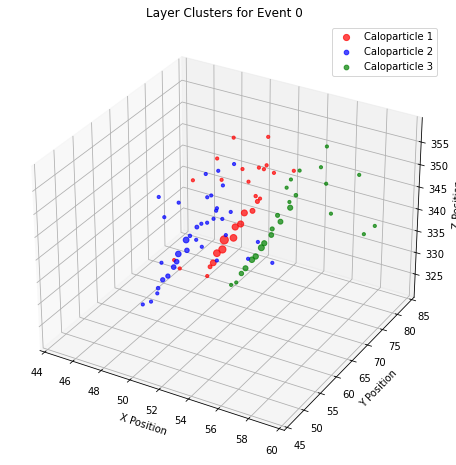

In [12]:
# tracksters

#------------------- Plot in 3D detector space ---------------------------------
# Select Event 0
event_idx = 0
x_event = tTrack_x[event_idx]  # Shape: (num_caloparticles, num_layer_clusters)
y_event = tTrack_y[event_idx]
z_event = tTrack_z[event_idx]
energy_event = tTrack_energy[event_idx]

# Flatten layer cluster arrays for indexing
flat_x = ak.flatten(x_event)
flat_y = ak.flatten(y_event)
flat_z = ak.flatten(z_event)
flat_energy = ak.flatten(energy_event)

# Define Colors for Caloparticles
num_caloparticles = len(x_event)
colors = ['r', 'b', 'g', 'c', 'm', 'y']  # Extend if more caloparticles exist

# Enable interactive 3D plots
#%matplotlib notebook 

# Create 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Each Caloparticle Separately
for i in range(num_caloparticles):
    x = x_event[i]
    y = y_event[i]
    z = z_event[i]
    energy = energy_event[i]

    # Scale marker size with energy (adjust factor for better visibility)
    marker_sizes = np.clip(energy * 10, 10, 500)  # Scale and set limits

    # Plot scatter with individual color
    ax.scatter(x, y, z, s=marker_sizes, color=colors[i % len(colors)], alpha=0.7, label=f'Caloparticle {i+1}')

# Labels & Legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_xlim([44,60])
ax.set_ylim([45,85])
ax.set_title('Layer Clusters for Event 0')
ax.legend()

# Show Plot
plt.show()

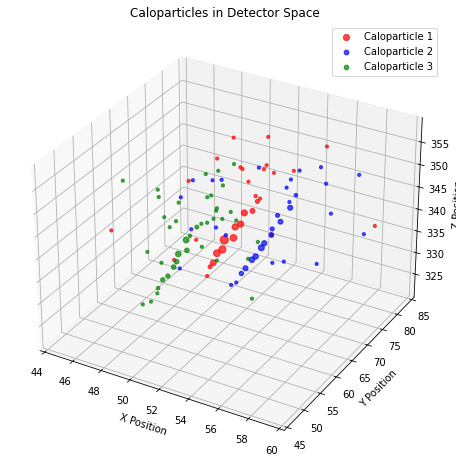

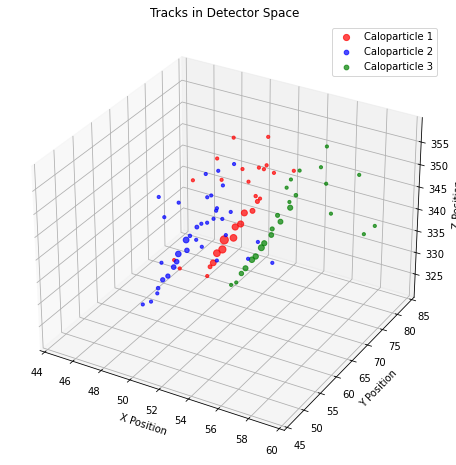

In [14]:
# define plotting in detector space as a function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import awkward as ak  # Assuming awkward arrays are used

# Enable interactive 3D plots
#%matplotlib notebook  

def plot_3D_event(x_data, y_data, z_data, energy_data, title="3D Event Display"):
    """
    Function to plot 3D positions of layer clusters in detector space.
    
    Parameters:
        x_data (array-like): X positions of layer clusters
        y_data (array-like): Y positions of layer clusters
        z_data (array-like): Z positions of layer clusters
        energy_data (array-like): Energy values of layer clusters
        title (str): Title of the plot
    """
    # Select Event 0
    event_idx = 0
    x_event = x_data[event_idx]  
    y_event = y_data[event_idx]
    z_event = z_data[event_idx]
    energy_event = energy_data[event_idx]

    # Flatten layer cluster arrays for indexing
    flat_x = ak.flatten(x_event)
    flat_y = ak.flatten(y_event)
    flat_z = ak.flatten(z_event)
    flat_energy = ak.flatten(energy_event)

    # Define Colors for Caloparticles
    num_caloparticles = len(x_event)
    colors = ['r', 'b', 'g', 'c', 'm', 'y']  # Extend if more caloparticles exist

    # Create 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Each Caloparticle Separately
    for i in range(num_caloparticles):
        x = x_event[i]
        y = y_event[i]
        z = z_event[i]
        energy = energy_event[i]

        # Scale marker size with energy (adjust factor for better visibility)
        marker_sizes = np.clip(energy * 10, 10, 500)  # Scale and set limits

        # Plot scatter with individual color
        ax.scatter(x, y, z, s=marker_sizes, color=colors[i % len(colors)], alpha=0.7, label=f'Caloparticle {i+1}')

    # Labels & Legend
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_xlim([44, 60])
    ax.set_ylim([45, 85])
    ax.set_title(title)
    ax.legend()

    # Show Plot
    plt.show()

# ---------------- PLOT CALOPARTICLES ----------------
plot_3D_event(CP_x, CP_y, CP_z, CP_energy, title="Caloparticles in Detector Space")
# ---------------- PLOT TRACKS ----------------
plot_3D_event(tTrack_x, tTrack_y, tTrack_z, tTrack_energy, title="Tracks in Detector Space")



17


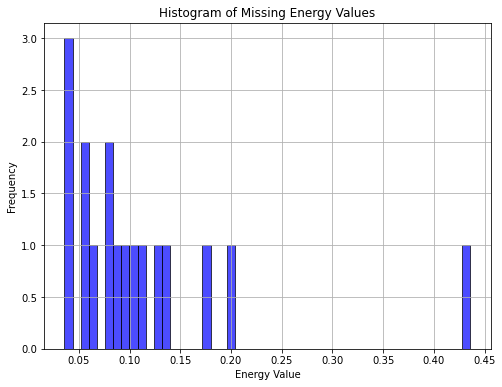

17
Multiplicities of Missing Indices: [1.0917431116104126, 1.1105990409851074, 2.529411792755127, 1.0, 1.0, 1.0, 1.2616822719573975, 3.118870973587036, 13.616608619689941, 1.2364341020584106, 4.72672176361084, 1.0, 1.8095238208770752, 1.0, 1.0, 1.017518162727356, 1.8493151664733887]


In [25]:
# Feature distributions of the additional LCs missing for event 0

# Flatten the arrays
all_lc_CP = ak.flatten(CP_ind[0]) #<--- data_train.stsCP
all_lc_Track = ak.flatten(tTrack_ind[0]) #<--- data_train.ststs

# Find indices in GT_ind but NOT in Track_ind
missing_indices = np.setdiff1d(all_lc_CP, all_lc_Track)
print(len(missing_indices))

missing_energy_dbn = tenergies[0][missing_indices] 

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(missing_energy_dbn, bins=50, color='blue', alpha=0.7, edgecolor='black')

# Labels and title
plt.xlabel('Energy Value')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Energy Values')
plt.grid(True)

# Show plot
plt.show()

# ---------------- Find Multiplicities of Missing Indices ---------------- #

GT_ind_with_repeats = data_train.stsCP_vertices_indexes_repeats_only
GT_mult_with_repeats = data_train.stsCP_vertices_multiplicity_repeats_only

# Flatten GT_ind[0] for searching
flattened_GT_ind = ak.flatten(GT_ind_with_repeats[0])
flattened_GT_mult = ak.flatten(GT_mult_with_repeats[0])

# Find the positions of missing indices in GT_ind[0]
missing_positions = [np.where(flattened_GT_ind == idx)[0][0] for idx in missing_indices if idx in flattened_GT_ind]

# Extract corresponding multiplicities from GT_mult[0] using these positions
missing_multiplicities = flattened_GT_mult[missing_positions]
print(len(missing_multiplicities))

# Print all multiplicities of missing indices
print("Multiplicities of Missing Indices:", list(missing_multiplicities))


Missing Energy values: [0.0837, 0.1, 0.0359, 0.0851, 0.0434, ... 0.174, 0.115, 0.0836, 0.436, 0.0668]


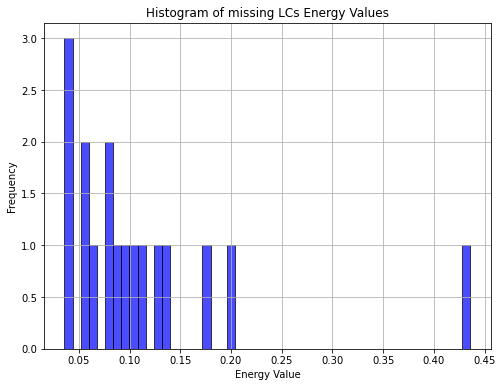

Missing Time values: [-99, -99, -99, -99, -99, -99, -99, -99, ... -99, -99, -99, -99, -99, -99, -99, -99]


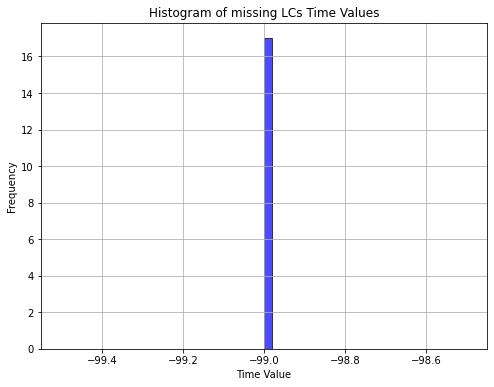

Missing layer_id values: [7, 8, 10, 10, 10, 11, 12, 12, 12, 14, 14, 15, 15, 15, 17, 17, 19]


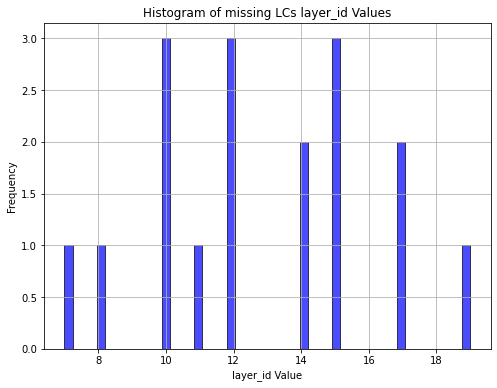

Missing type values: [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]


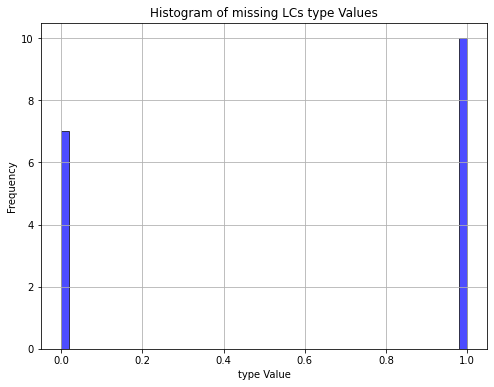

Missing noh values: [2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 3, 2, 3, 3, 2, 2, 2]


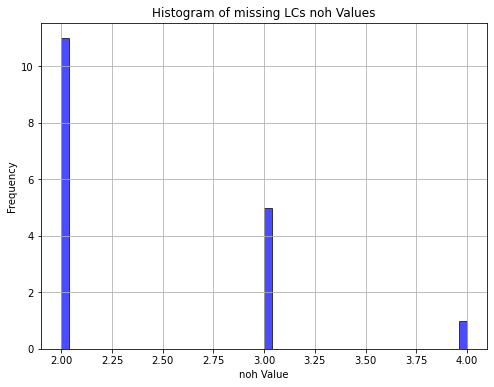

Missing eta values: [2.11, 1.99, 2.09, 2.06, 2.03, 2.14, 2.22, ... 2.1, 2.28, 2.09, 2.14, 2.2, 2.1, 2.09]


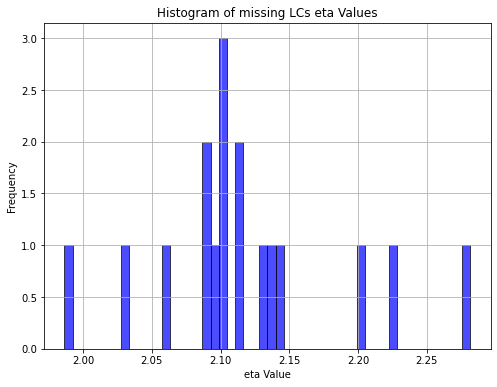

Missing phi values: [0.833, 0.974, 0.957, 0.884, 0.881, 0.939, ... 0.987, 0.966, 0.954, 0.956, 0.951]


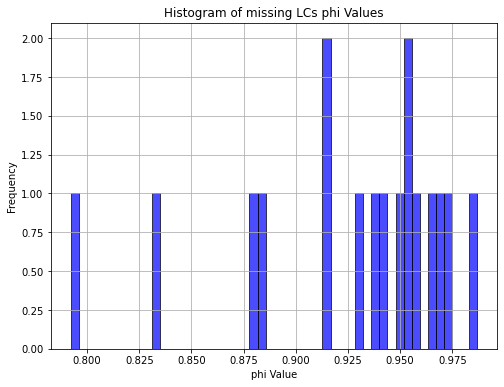

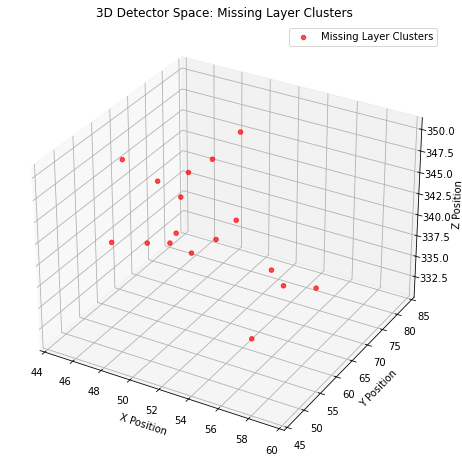

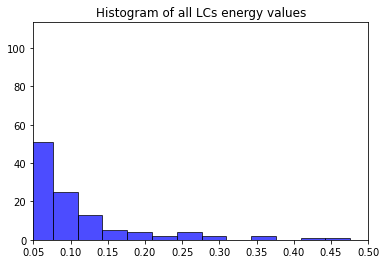

In [19]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import awkward as ak  

def plot_missing_feature(CP_ind, Track_ind, feature_array, feature_name="Feature", bins=50):
    """
    Plots a histogram of a selected feature for missing indices (indices in CP_ind but not in Track_ind).
    
    Parameters:
        CP_ind (array-like): Indices from Caloparticles (stsCP)
        Track_ind (array-like): Indices from Tracks (ststs)
        feature_array (array-like): The feature values to analyze (e.g., energy, time, x positions)
        feature_name (str): Name of the feature being plotted
        bins (int): Number of bins for histogram visualization
    """
    # Flatten the arrays
    all_lc_CP = ak.flatten(CP_ind[0])  # stsCP indices
    all_lc_Track = ak.flatten(Track_ind[0])  # ststs indices

    # Find missing indices (present in CP_ind but not in Track_ind)
    missing_indices = np.setdiff1d(all_lc_CP, all_lc_Track)

    # Extract the feature values for missing indices
    missing_feature_values = feature_array[0][missing_indices]

    # Print missing feature values (optional for debugging)
    print(f"Missing {feature_name} values:", missing_feature_values)

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(missing_feature_values, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Labels and title
    plt.xlabel(f'{feature_name} Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of missing LCs {feature_name} Values')
    plt.grid(True)

    # Show plot
    plt.show()

# Example Usage:
# Plot missing energy values
plot_missing_feature(CP_ind, tTrack_ind, tenergies, feature_name="Energy")

# Plot missing time values
plot_missing_feature(CP_ind, tTrack_ind, ttime, feature_name="Time")

# Plot missing x-position values
plot_missing_feature(CP_ind, tTrack_ind, tlayerid, feature_name="layer_id")

# Plot missing x-position values
plot_missing_feature(CP_ind, tTrack_ind, ttype, feature_name="type")

# Plot missing x-position values
plot_missing_feature(CP_ind, tTrack_ind, tnoh, feature_name="noh")

# Plot missing x-position values
plot_missing_feature(CP_ind, tTrack_ind, teta, feature_name="eta")

# Plot missing x-position values
plot_missing_feature(CP_ind, tTrack_ind, tphi, feature_name="phi")

# Extract missing x, y, z positions
missing_x = t_x[0][missing_indices]
missing_y = t_y[0][missing_indices]
missing_z = t_z[0][missing_indices]

# Create interactive 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot missing LCs in 3D
ax.scatter(missing_x, missing_y, missing_z, color='red', alpha=0.7, label='Missing Layer Clusters')

# Labels & Legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_xlim([44,60])
ax.set_ylim([45,85])
ax.set_title('3D Detector Space: Missing Layer Clusters')
ax.legend()

# Show plot
plt.show()

plt.hist(tenergies[0], bins=200, color='blue', alpha=0.7, edgecolor='black')
plt.title("Histogram of all LCs energy values")
plt.xlim(0.05,0.5)
plt.show()

## End of intermission

In [6]:
#3: Make Predictions + Cluster -> Calculate the inference time
#3.1: Make Predictions

# Load test data
data_test2 = CCV2(testpath, max_events=99)
test_loader = DataLoader(data_test2, batch_size=1, shuffle=False, follow_batch=['x'])

all_predictions = []  
total_times = []
start_time = time.time()

for i, data in enumerate(test_loader):
    predictions = model(data.x, data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

#3.2: Cluster using threshold found in Script A

all_cluster_labels = Aggloremative(all_predictions, threshold = 0.5)

end_time = time.time()

#3.3: Calculate average inference time

time_diff = end_time - start_time
inference_time = time_diff/len(all_cluster_labels)
print("average inference time:", inference_time)

### Loading data


  0%|                                                                                             | 0/1 [00:03<?, ?it/s]

Reached 99!



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


average inference time: 3.577784547805786


In [6]:
# Extract layer cluster indices corresponding to all_predictions
def has_duplicates(arr):
    return len(arr) != len(set(arr))


all_cluster_idx = []
for i, data in enumerate(test_loader):
    all_cluster_idx.append(data.idx[0].flatten())
all_cluster_idx = np.array(all_cluster_idx)

print(has_duplicates(all_cluster_idx[0]))

False


In [16]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):
    event_clusters = {} 
    #print(len(labels))
    #print(len(all_cluster_idx[event_idx]))
    #print(data.idx.flatten())
    #print(data.idx)
    #flat_GT_ind = ak.flatten(GT_ind[event_idx])
    
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].append(all_cluster_idx[event_idx][cluster_idx])
    
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

recon_ind = ak.Array(recon_ind)
recon_mult = ak.Array([[[1 for _ in sublist] for sublist in event] for event in recon_ind])

#4.2 Make DF from our model and CERN

df_CL = calculate_all_event_scores(GT_ind, GT_mult, GT_regressed_energy, energies, recon_ind, recon_mult, num_events = 100)
df_TICL = calculate_all_event_scores(GT_ind, GT_mult, GT_regressed_energy, energies, Track_ind, Track_mult, num_events = 100)

In [12]:
df_CL

,event_index,cp_id,trackster_id,reco_to_sim_score,cp_raw_energy,cp_regressed_energy,trackster_energy,shared_energy
0,0,0,0,4.080721e-05,180.986489,189.318832,181.580247,180.472495
1,0,0,1,9.788284e-01,180.986489,189.318832,36.642162,0.513994
2,0,1,0,9.999872e-01,12.831773,13.749559,181.580247,0.239595
3,0,1,1,6.275262e-01,12.831773,13.749559,36.642162,12.592179
4,0,2,0,9.985158e-01,24.404146,26.827173,181.580247,0.868156
...,...,...,...,...,...,...,...,...
585,98,0,0,3.492501e-05,56.542662,58.054249,56.465563,56.244744
586,98,0,1,9.879259e-01,56.542662,58.054249,14.359043,0.297918
587,98,1,0,9.999427e-01,14.189851,15.507558,56.465563,0.152677
588,98,1,1,2.429879e-03,14.189851,15.507558,14.359043,14.037174


In [8]:
#debugging

def has_duplicates(arr):
    return len(arr) != len(set(arr))

arr = recon_ind[0][0]
print(has_duplicates(arr)) 

True


In [50]:
# Debugging



def calculate_reco_to_sim_score_and_sharedE(ReconstructedTrackster, energies_indices, CaloParticle, track_mult, calo_mult):
    """
    Calculate the reco-to-sim score for a given ReconstructedTrackster and CaloParticle.

    Parameters:
    - ReconstructedTrackster: array of DetIds in the ReconstructedTrackster.
    - energies_indices: array of energies associated with all DetIds (indexed by DetId).
    - CaloParticle: array of DetIds in the CaloParticle.

    Returns:
    - reco_to_sim_score: the calculated reco-to-sim score.
    """
    numerator = 0.0
    denominator = 0.0
    sharedEnergy = 0.0

    # Iterate over all DetIds in the ReconstructedTrackster
    for i, det_id in enumerate(ReconstructedTrackster):
        energy_k = energies_indices[det_id]  # Energy for the current DetId in the Trackster
        
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1 / track_mult[i]

        #Fraction of energy in the caloparticle
        if det_id in CaloParticle:
            index = np.where(CaloParticle == det_id)[0][0]
            #print(index)
            fr_sc_k = 1 / calo_mult[index]
            
        else:
            fr_sc_k = 0 # binary function also for CaloParticle
            
        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_tst_k ** 2               # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_tst_k ** 2) * (energy_k ** 2)
        
        #shared_energy calculation
        recosharedEnergy = energy_k * fr_tst_k
        simsharedEnergy = energy_k * fr_sc_k
        sharedEnergy += min(simsharedEnergy,recosharedEnergy) # min is always simsharedEnergy

        #print("sims: " ,simsharedEnergy)
        #print("reco: ",recosharedEnergy)
        #print("min: ", min(simsharedEnergy,recosharedEnergy))
        #print(simsharedEnergy == min(simsharedEnergy,recosharedEnergy))
        #print("---")
    # Calculate score
    reco_to_sim_score = numerator / denominator if denominator != 0 else 1.0
    return reco_to_sim_score, sharedEnergy



print(calculate_reco_to_sim_score_and_sharedE(recon_ind[0][0], energies[0], GT_ind[0][0], recon_mult[0][0], GT_mult[0][0]))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
40
41
42
43
44
46
47
48
49
50
51
52
53
54
55
57
58
60
62
63
64
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
89
58
83
64
8
89
68
11
10
83
84
82
0
(4.221367462146286e-05, 223.9431020491092)


In [54]:
def has_duplicates(arr):
    return len(arr) != len(set(arr))

arr = recon_ind[0][0]
print(has_duplicates(arr)) 

True


In [37]:
print(np.sum(energies[0][GT_ind[0][0]] / GT_mult[0][0]))

180.98648896834925


In [17]:
#5: Print metrics

def calculate_metrics(df, model_name):
    # ----- Efficiency Calculation -----
    # Step 1: Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()

    # Step 2: Group by 'event_index' and 'cp_id' to proess each CaloParticle individually
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])

    # Step 3: For each CaloParticle, check if any 'shared_energy' >= 50% of 'cp_raw_energy'
    def is_cp_associated(group):
        cp_raw_energy = group['cp_raw_energy'].iloc[0]  # Assuming 'cp_raw_energy' is consistent within the group
        threshold = 0.7 * cp_raw_energy
        return (group['shared_energy'] >= threshold).any()

    # Apply the association function to each group
    cp_associated = cp_grouped.apply(is_cp_associated)

    # Step 4: Calculate the number of associated CaloParticles and total CaloParticles
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0
    
    # ----- Ratio between num of tracksters to caloparticles Calculation -----
    num_tracksters_ratio = total_tst / total_cp if total_cp > 0 else 0
    
    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency: {efficiency:.4f} ({num_associated_cp} associated CPs out of {total_cp} total CPs)")
    print(f"Purity: {purity:.4f} ({num_associated_tst} associated Tracksters out of {total_tst} total Tracksters)")
    print(f"Num tracksters ratio: {num_tracksters_ratio}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'Num_tracksters_ratio': num_tracksters_ratio,
    }

# Example usage
your_model_metrics = calculate_metrics(df_CL, "Your Model")
cern_model_metrics = calculate_metrics(df_TICL, "CERN Model")


Model: Your Model
Efficiency: 0.9684 (276 associated CPs out of 285 total CPs)
Purity: 0.8514 (298 associated Tracksters out of 350 total Tracksters)
Num tracksters ratio: 1.2280701754385965

Model: CERN Model
Efficiency: 0.9684 (276 associated CPs out of 285 total CPs)
Purity: 0.9333 (350 associated Tracksters out of 375 total Tracksters)
Num tracksters ratio: 1.3157894736842106


## Section 2: Plotting metrics against energy
* Efficiency vs caloparticle energy, $E_{cp}$:
$$\text{Efficiency for energy bin } E_{cp,1} < E_{cp} < E_{cp,2} = 
\frac{\text{Number of associated caloparticles with energy $E_{cp}$ in } E_{cp,1} < E_{cp} < E_{cp,2}}{\text{Number of caloparticles with energy $E_{cp}$ in }  E_{cp,1} < E_{cp} < E_{cp,2}} $$
* Purity vs trackster energy, $E_{tst}$:
$$\text{Purity for energy bin } E_{tst,1} < E_{tst} < E_{tst,2} = 
\frac{\text{Number of associated tracksters with energy $E_{tst}$ in } E_{tst,1} < E_{tst} < E_{tst,2}}{\text{Number of tracksters with energy $E_{tst}$ in } E_{tst,1} < E_{tst} < E_{tst,2}} $$



* We plot efficiency against caloparticle energy rather than trackster energy since when calculating efficiency, we count the number of caloparticles that are both associated or unassociated to some trackster. Unassociated caloparticles cannot be assigned a meaningful trackster energy (what trackster would we pair it with?) and so we have to use their caloparticle energy when classifying them into energy bins.


* In a similar fashion, we plot purity against trackster enery rather than caloparticle energy since when calculating purity, we also count the number of tracksters that have not been associated to a caloparticle. Again, unassociated tracksters cannot be assigned a meaningful caloparticle energy.

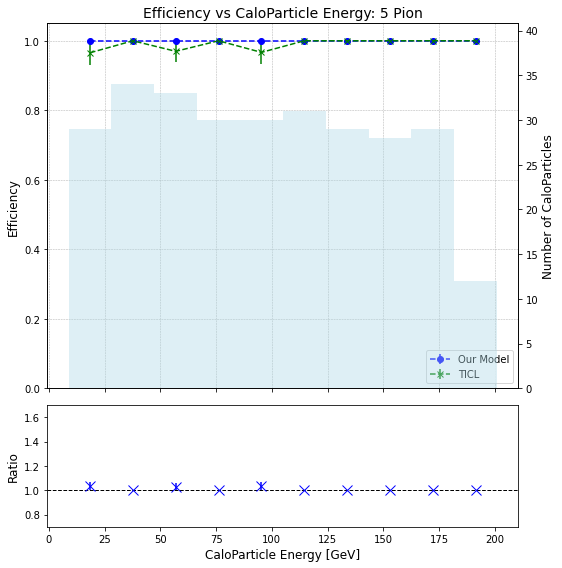

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_CL and df_TICL are your two DataFrames
# Replace the following with your actual data loading mechanism
# df_CL = pd.read_csv('df_CL.csv')
# df_TICL = pd.read_csv('df_TICL.csv')

# ----- Preprocessing -----
# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')  # New Column
    df['cp_raw_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')

def prepare_cp_data(df):
    """
    Group the DataFrame by ['event_index', 'cp_id'] so that each caloparticle is counted once.
    For each group:
      - Take the first cp_raw_energy (they are identical).
      - Take the maximum shared_energy to check if any shared_energy >= 50% of cp_raw_energy.
      - Mark the caloparticle as 'reconstructed' if any shared_energy >= 50% of cp_raw_energy.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_raw_energy': 'first',          
        'shared_energy': 'max'        # Use max to determine if any shared_energy meets the threshold
    }).reset_index()
    
    # Mark as reconstructed if any shared_energy >= 50% of cp_raw_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_raw_energy']).astype(int)
    return grouped

# Prepare the caloparticle data for both DataFrames.
df_CL_cp = prepare_cp_data(df_CL)
df_TICL_cp = prepare_cp_data(df_TICL)

# ----- Bin Caloparticles by Energy -----
# Define energy bins based on the range of cp_raw_energy from df_CL.
min_energy = df_CL_cp['cp_raw_energy'].min()
max_energy = df_CL_cp['cp_raw_energy'].max()
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)

# Assign each caloparticle to an energy bin.
df_CL_cp['energy_bin'] = pd.cut(df_CL_cp['cp_raw_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_raw_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ----- Calculate Efficiency per Energy Bin -----
def aggregate_efficiency(df):
    """
    For each energy bin, calculate:
      - The total number of caloparticles in the bin.
      - The number of reconstructed caloparticles.
      - Efficiency = (number of reconstructed) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_raw_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

agg_CL = aggregate_efficiency(df_CL_cp)
agg_TICL = aggregate_efficiency(df_TICL_cp)

# ----- Plot Efficiency vs Energy with Histogram Overlay -----
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

eff_ratio = agg_CL['efficiency'] / agg_TICL['efficiency']
eff_ratio_error = eff_ratio * np.sqrt(
    (agg_CL['eff_error'] / agg_CL['efficiency'])**2 + 
    (agg_TICL['eff_error'] / agg_TICL['efficiency'])**2
)


# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)


# Plot Efficiency
ax1.errorbar(bin_centers, agg_CL['efficiency'], yerr=agg_CL['eff_error'], marker='o',linestyle ='--',  color='blue', label='Our Model')
ax1.errorbar(bin_centers, agg_TICL['efficiency'], yerr=agg_TICL['eff_error'],   marker='x', linestyle ='--', color='green', label='TICL')
ax1.set_ylabel('Efficiency', fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)



# ----- Histogram for Number of CaloParticles -----
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers, agg_CL['total_cp'], width=bar_width, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of CaloParticles', fontsize=12)
ax1_hist.set_ylim(0, agg_CL['total_cp'].max() * 1.2)

# ----- Ratio Plot -----
ax2.errorbar(bin_centers, eff_ratio, yerr=eff_ratio_error, fmt='x', color='blue', markersize=10)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('CaloParticle Energy [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.7, 1.7)

# Update Title to Reflect New Efficiency Definition
plt.title(r'Efficiency vs CaloParticle Energy: 5 Pion', fontsize=14)
plt.tight_layout()
plt.savefig("plots/efficiency.png")
plt.show()

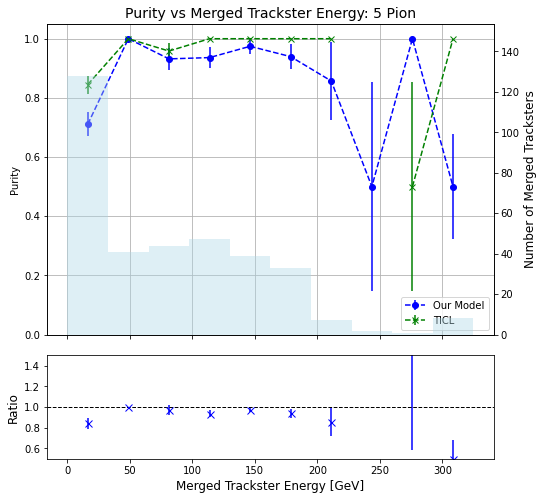

In [19]:

# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for Purity
# -----------------------------
def prepare_trackster_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first trackster_energy,
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',       # Use the first trackster_energy value.
        'reco_to_sim_score': 'min'           # Minimum score among the rows for that trackster.
    }).reset_index()
    
    # Mark as associated if reco_to_sim_score is < 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_ts = prepare_trackster_data(df_CL)
df_TICL_ts   = prepare_trackster_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of trackster_energy from df_CL.
min_energy_ts = df_CL_ts['trackster_energy'].min()
max_energy_ts = df_CL_ts['trackster_energy'].max()
n_bins_ts = 10  # Adjust the number of bins if desired.
energy_bins_ts = np.linspace(min_energy_ts, max_energy_ts, n_bins_ts + 1)

# Assign each trackster to an energy bin.
df_CL_ts['energy_bin'] = pd.cut(df_CL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)
df_TICL_ts['energy_bin']   = pd.cut(df_TICL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)

# -----------------------------
# Calculate Purity per Energy Bin
# -----------------------------
def aggregate_purity(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - Purity = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_ts = ('trackster_energy', 'count'),
        assoc_ts = ('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

agg_CL_ts = aggregate_purity(df_CL_ts)
agg_TICL_ts   = aggregate_purity(df_TICL_ts)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_ts-1)
agg_CL_ts = agg_CL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()
agg_TICL_ts   = agg_TICL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()

# -----------------------------
# Plot Purity vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_ts = (energy_bins_ts[:-1] + energy_bins_ts[1:]) / 2
bar_width_ts = energy_bins_ts[1] - energy_bins_ts[0]

purity_ratio = agg_CL_ts['purity'] / agg_TICL_ts['purity']
purity_ratio_error = purity_ratio * np.sqrt(
    (agg_CL_ts['purity_error'] / agg_CL_ts['purity'])**2 +
    (agg_TICL_ts['purity_error'] / agg_TICL_ts['purity'])**2
)

# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

plt.subplots_adjust(hspace=0.1)  # Set spacing to zero

# Plot purity curves on the primary y-axis.
ax1.errorbar(bin_centers_ts, agg_CL_ts['purity'], yerr=agg_CL_ts['purity_error'], marker='o', linestyle='--', color = 'blue', label='Our Model')
ax1.errorbar(bin_centers_ts, agg_TICL_ts['purity'], yerr = agg_TICL_ts['purity_error'], marker='x', linestyle='--', color = 'green', label='TICL')
ax1.set_ylabel('Purity')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot histogram (trackster count per energy bin) on the secondary y-axis.
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers_ts, agg_CL_ts['total_ts'], width=bar_width_ts, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_CL_ts['total_ts'].max() * 1.2)

ax2.errorbar(bin_centers_ts, purity_ratio, yerr=purity_ratio_error, fmt='x', color='blue', markersize=7)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Merged Trackster Energy [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.5, 1.5)

plt.title(r'Purity vs Merged Trackster Energy: 5 Pion', fontsize=14)
plt.savefig("plots/purity.png")
plt.show()

## Section 3: Response and Resolution plots

We ran three iterations when creating our response and resolution plots, reflecting the different definitions for caloparticle-trackster association:
1. Response and resolution vs trackster energy (reco_to_sim score only)
2. Response and resolution vs caloparticle energy (sim_to_reco score only)
3. Response and resolution vs caloparticle energy (reco_to_sim score and sim_to_reco score)

$$ \text{energy ratio} = \frac{E_{\text{reconstructed}}}{E_{\text{true}}}$$


where a reconstructed particle and true particle pair in the above ratio is defined as:
1. a trackster and the caloparticle it has the smallest reco_to_sim score < 0.2 with (the best caloparticle associated to it). Note that tracksters not associated at all are ignored.
2. a caloparticle and the trackster it has the smallest sim_to_reco score < 0.2 with (the best trackster associated to it). Note that caloparticles not associated at all are ignored.
3. a caloparticle and the trackster it has the smallest sim_to_reco < 0.2 score with, provided that the reco_to_sim score is also < 0.2. Those caloparticle and trackster combinations that don't have sim_to_reco < 0.2 AND reco_to_sim < 0.2 are ignored. The logic behind this is that why should the association be uni-directional? Surely it should be symmetric in both directions when considering reconstruction performance in the context of response and resolution.

respectively.

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


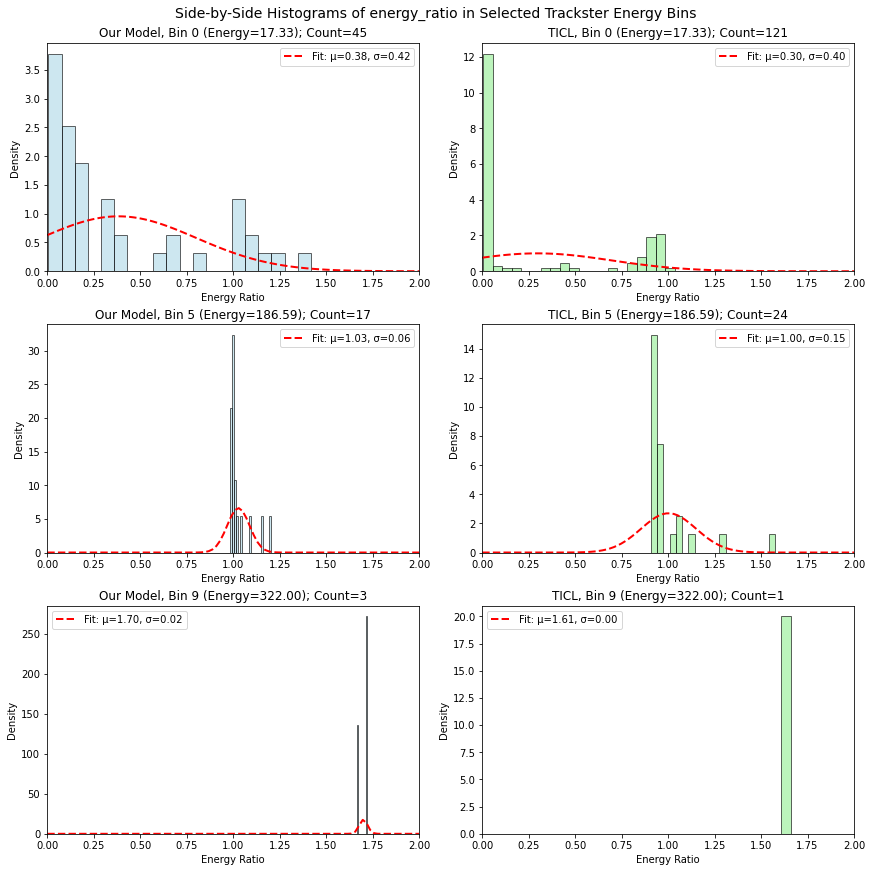

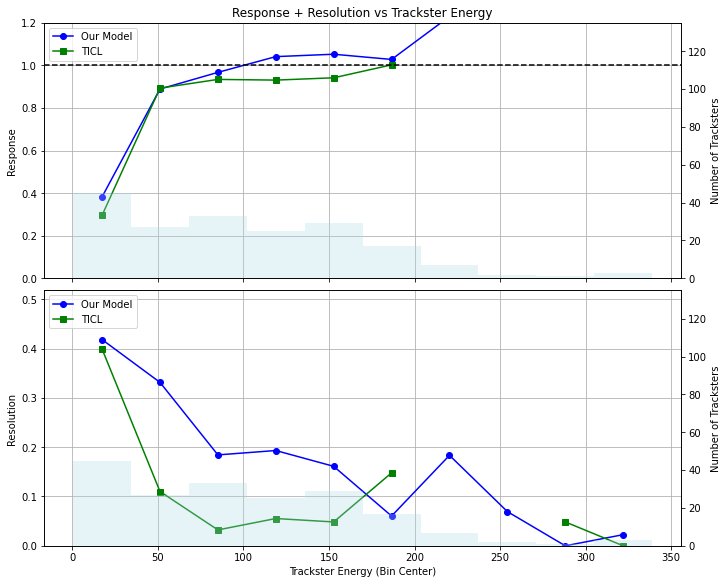

In [11]:
# iteration 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ====================================================
# 1. Preprocessing and Association Selection
# ====================================================
def process_dataframe(df):
    """
    Convert relevant columns to numeric, select associated tracksters (reco_to_sim_score < 0.2),
    and for tracksters with multiple associations, keep only the row with the lowest reco_to_sim_score.
    """
    for col in ['trackster_id', 'reco_to_sim_score', 'trackster_energy', 'energy_ratio']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df_assoc = df[df['reco_to_sim_score'] < 0.2].copy()
    
    # For each event and trackster, keep the row with the lowest reco_to_sim_score.
    df_assoc = (df_assoc.groupby(['event_index', 'trackster_id'], as_index=False)
                .apply(lambda g: g.loc[g['reco_to_sim_score'].idxmin()])
                .reset_index(drop=True))
    return df_assoc

# Process both dataframes.
df_CL_assoc   = process_dataframe(df_CL)
df_TICL_assoc = process_dataframe(df_TICL)

# ====================================================
# 2. Binning by Trackster Energy
# ====================================================
n_bins = 10
# Use the energy range from df_CL_assoc as the common binning.
min_energy = df_CL_assoc['trackster_energy'].min()
max_energy = df_CL_assoc['trackster_energy'].max()
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

# Assign each trackster to an energy bin.
df_CL_assoc['energy_bin']   = pd.cut(df_CL_assoc['trackster_energy'],
                                      bins=energy_bins, labels=False, include_lowest=True)
df_TICL_assoc['energy_bin'] = pd.cut(df_TICL_assoc['trackster_energy'],
                                      bins=energy_bins, labels=False, include_lowest=True)

# ====================================================
# 3. Gaussian Fit in Each Energy Bin & Count Aggregation
# ====================================================
def fit_bins(df, n_bins):
    fitted_mean = []
    fitted_sigma = []
    counts = []  # Number of tracksters per bin.
    for b in range(n_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mu, sigma = norm.fit(bin_data)
        else:
            mu, sigma = np.nan, np.nan
        fitted_mean.append(mu)
        fitted_sigma.append(sigma)
    return np.array(fitted_mean), np.array(fitted_sigma), np.array(counts)

fitted_mean_CL, fitted_sigma_CL, counts_CL     = fit_bins(df_CL_assoc, n_bins)
fitted_mean_TICL, fitted_sigma_TICL, counts_TICL = fit_bins(df_TICL_assoc, n_bins)

# ====================================================
# 4. Plot Side-by-Side Histograms for Selected Bins
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
n_sel = len(selected_bins)
fig_hist, axs = plt.subplots(n_sel, 2, figsize=(12, 4 * n_sel), constrained_layout=True)
xlim_range = (0, 2)  # Fixed x-axis for all histograms

for i, b in enumerate(selected_bins):
    # For df_CL histogram:
    data_CL = df_CL_assoc.loc[df_CL_assoc['energy_bin'] == b, 'energy_ratio'].dropna()
    ax_left = axs[i, 0] if n_sel > 1 else axs[0]
    n_CL, bins_CL, _ = ax_left.hist(data_CL, bins=20, density=True,
                                    color='lightblue', alpha=0.6, edgecolor='k')
    ax_left.set_xlim(xlim_range)
    if len(data_CL) > 0:
        mu_CL = fitted_mean_CL[b]
        sigma_CL = fitted_sigma_CL[b]
        x_fit = np.linspace(xlim_range[0], xlim_range[1], 100)
        p_CL = norm.pdf(x_fit, mu_CL, sigma_CL)
        ax_left.plot(x_fit, p_CL, 'r--', linewidth=2,
                     label=f'Fit: μ={mu_CL:.2f}, σ={sigma_CL:.2f}')
    ax_left.set_title(f'Our Model, Bin {b} (Energy={bin_centers[b]:.2f}); Count={len(data_CL)}')
    ax_left.set_xlabel('Energy Ratio')
    ax_left.set_ylabel('Density')
    ax_left.legend(fontsize=10)
    
    # For df_TICL histogram:
    data_TICL = df_TICL_assoc.loc[df_TICL_assoc['energy_bin'] == b, 'energy_ratio'].dropna()
    ax_right = axs[i, 1] if n_sel > 1 else axs[1]
    n_TICL, bins_TICL, _ = ax_right.hist(data_TICL, bins=20, density=True,
                                          color='lightgreen', alpha=0.6, edgecolor='k')
    ax_right.set_xlim(xlim_range)
    if len(data_TICL) > 0:
        mu_TICL = fitted_mean_TICL[b]
        sigma_TICL = fitted_sigma_TICL[b]
        x_fit = np.linspace(xlim_range[0], xlim_range[1], 100)
        p_TICL = norm.pdf(x_fit, mu_TICL, sigma_TICL)
        ax_right.plot(x_fit, p_TICL, 'r--', linewidth=2,
                      label=f'Fit: μ={mu_TICL:.2f}, σ={sigma_TICL:.2f}')
    ax_right.set_title(f'TICL, Bin {b} (Energy={bin_centers[b]:.2f}); Count={len(data_TICL)}')
    ax_right.set_xlabel('Energy Ratio')
    ax_right.set_ylabel('Density')
    ax_right.legend(fontsize=10)

plt.suptitle('Side-by-Side Histograms of energy_ratio in Selected Trackster Energy Bins', fontsize=14)
plt.show()

# ====================================================
# 5. Plot Fitted Mean and Sigma vs Energy Bin Centers with df_CL Trackster Count
# ====================================================
# For the final comparison, plot both datasets on the same plots.
bar_width = energy_bins[1] - energy_bins[0]

fig_params, (ax_mu, ax_sigma) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

# Plot the fitted means.
ax_mu.plot(bin_centers, fitted_mean_CL, marker='o', linestyle='-', color='blue', label='Our Model')
ax_mu.plot(bin_centers, fitted_mean_TICL, marker='s', linestyle='-', color='green', label='TICL')
ax_mu.set_ylabel('Response')
ax_mu.set_title('Response + Resolution vs Trackster Energy', fontsize=12)
ax_mu.grid(True)
ax_mu.legend(loc='upper left', fontsize=10)
ax_mu.set_ylim(0, 1.2)
ax_mu.axhline(1, color='k', linestyle='--')  # Dashed horizontal line at y = 1

# Create a twin axis to plot the df_CL trackster counts in the background.
ax_mu2 = ax_mu.twinx()
ax_mu2.bar(bin_centers, counts_CL, width=bar_width, color='lightblue', alpha=0.3)
ax_mu2.set_ylabel('Number of Tracksters')
ax_mu2.set_ylim(0, 3*counts_CL.max())

# Plot the fitted sigmas.
ax_sigma.plot(bin_centers, fitted_sigma_CL, marker='o', linestyle='-', color='blue', label='Our Model')
ax_sigma.plot(bin_centers, fitted_sigma_TICL, marker='s', linestyle='-', color='green', label='TICL')
ax_sigma.set_xlabel('Trackster Energy (Bin Center)')
ax_sigma.set_ylabel('Resolution')
ax_sigma.grid(True)
ax_sigma.legend(loc='upper left', fontsize=10)
ax_sigma.set_ylim(0, fitted_sigma_CL.max()+0.1)

# Twin axis for the df_CL trackster counts.
ax_sigma2 = ax_sigma.twinx()
ax_sigma2.bar(bin_centers, counts_CL, width=bar_width, color='lightblue', alpha=0.3)
ax_sigma2.set_ylabel('Number of Tracksters')
ax_sigma2.set_ylim(0, 3*counts_CL.max())

plt.show()

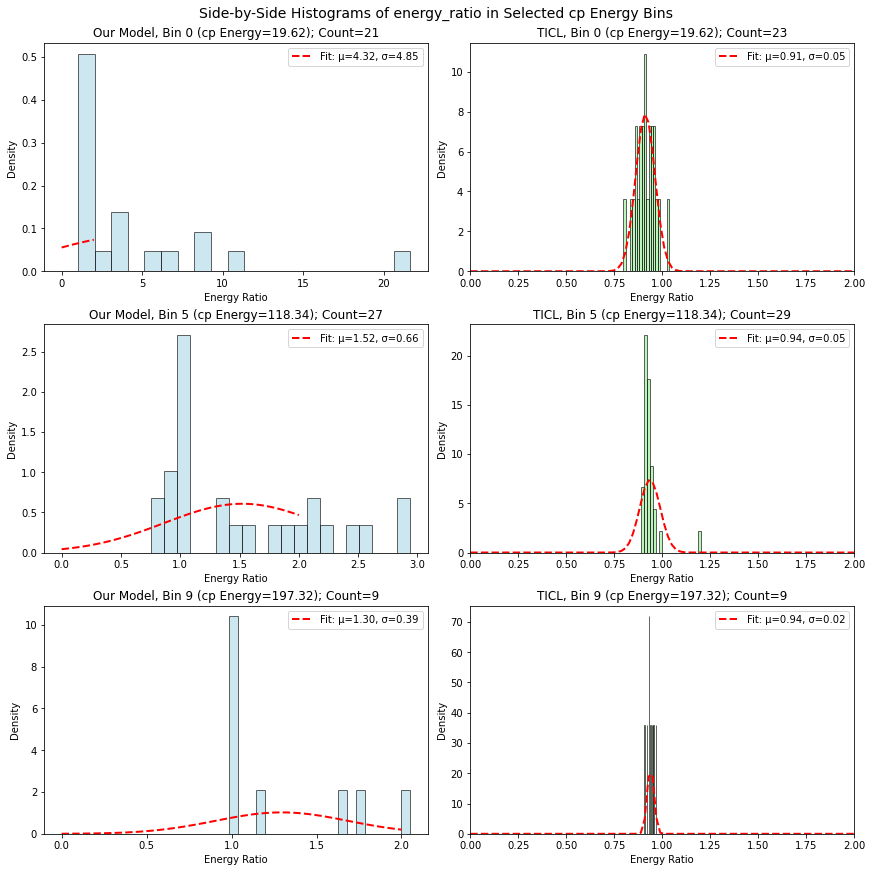

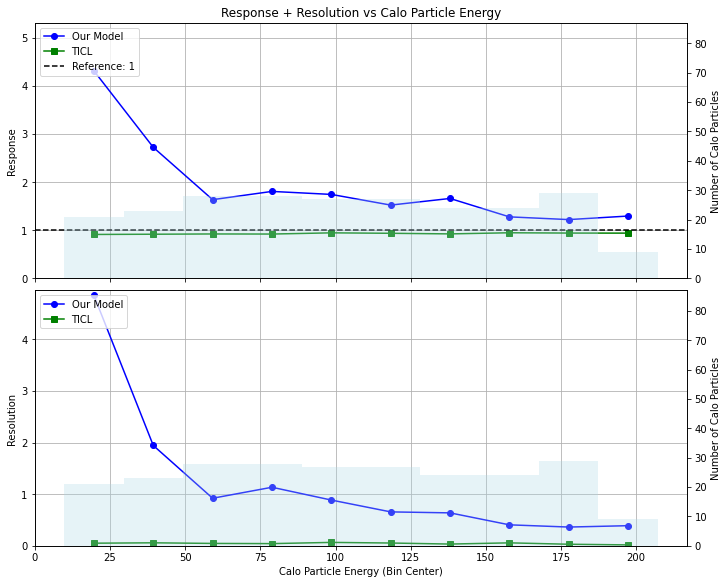

In [12]:
# iteration 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ====================================================
# 1. Preprocessing and Association Selection for Calo Particles
# ====================================================
def process_cp_dataframe(df):
    """
    Convert relevant columns to numeric, then for each calo particle (identified by event_index and cp_id):
      - Group the data and take the first cp_raw_energy value (assumed constant)
      - Compute the minimum sim_to_reco_score (i.e. best association)
      - Also take the energy_ratio from the best-associated trackster.
    Only keep those calo particles for which the minimum sim_to_reco_score < 0.2.
    """
    # Convert columns to numeric.
    for col in ['cp_id', 'sim_to_reco_score', 'cp_raw_energy', 'energy_ratio']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Keep only rows with a sim_to_reco_score < 0.2
    df_cp = df[df['sim_to_reco_score'] < 0.2].copy()
    
    # For each calo particle (cp_id per event) keep the row with the smallest sim_to_reco_score.
    df_cp = (df_cp.groupby(['event_index', 'cp_id'], as_index=False)
             .apply(lambda g: g.loc[g['sim_to_reco_score'].idxmin()])
             .reset_index(drop=True))
    return df_cp

# Process both dataframes
df_CL_cp   = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)

# ====================================================
# 2. Binning by Calo Particle Energy (cp_raw_energy)
# ====================================================
n_bins = 10
# Determine energy bins from the CL model (you can change this if needed)
min_energy = df_CL_cp['cp_raw_energy'].min()
max_energy = df_CL_cp['cp_raw_energy'].max()
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

# Assign each calo particle to an energy bin based on cp_raw_energy.
df_CL_cp['energy_bin']   = pd.cut(df_CL_cp['cp_raw_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_raw_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ====================================================
# 3. Gaussian Fit in Each Energy Bin & Count Aggregation
# ====================================================
def fit_bins(df, n_bins):
    """
    For each energy bin, take the energy_ratio values from the processed calo particles,
    fit a Gaussian (if data exists), and record the fitted mean (response) and sigma (resolution).
    Also record the number of calo particles in each bin.
    """
    fitted_mean = []
    fitted_sigma = []
    counts = []  # number of calo particles in the bin.
    for b in range(n_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mu, sigma = norm.fit(bin_data)
        else:
            mu, sigma = np.nan, np.nan
        fitted_mean.append(mu)
        fitted_sigma.append(sigma)
    return np.array(fitted_mean), np.array(fitted_sigma), np.array(counts)

fitted_mean_CL, fitted_sigma_CL, counts_CL     = fit_bins(df_CL_cp, n_bins)
fitted_mean_TICL, fitted_sigma_TICL, counts_TICL = fit_bins(df_TICL_cp, n_bins)

# ====================================================
# 4. Plot Side-by-Side Histograms for Selected Bins (First, Middle, Last)
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
n_sel = len(selected_bins)
fig_hist, axs = plt.subplots(n_sel, 2, figsize=(12, 4 * n_sel), constrained_layout=True)
xlim_range = (0, 2)  # fixed x-axis

for i, b in enumerate(selected_bins):
    # For df_CL histogram:
    data_CL = df_CL_cp.loc[df_CL_cp['energy_bin'] == b, 'energy_ratio'].dropna()
    ax_left = axs[i, 0] if n_sel > 1 else axs[0]
    n_CL, bins_CL, _ = ax_left.hist(data_CL, bins=20, density=True,
                                    color='lightblue', alpha=0.6, edgecolor='k')
    #ax_left.set_xlim(xlim_range)
    if len(data_CL) > 0:
        mu_CL = fitted_mean_CL[b]
        sigma_CL = fitted_sigma_CL[b]
        x_fit = np.linspace(xlim_range[0], xlim_range[1], 100)
        p_CL = norm.pdf(x_fit, mu_CL, sigma_CL)
        ax_left.plot(x_fit, p_CL, 'r--', linewidth=2,
                     label=f'Fit: μ={mu_CL:.2f}, σ={sigma_CL:.2f}')
    ax_left.set_title(f'Our Model, Bin {b} (cp Energy={bin_centers[b]:.2f}); Count={len(data_CL)}')
    ax_left.set_xlabel('Energy Ratio')
    ax_left.set_ylabel('Density')
    ax_left.legend(fontsize=10)
    
    # For df_TICL histogram:
    data_TICL = df_TICL_cp.loc[df_TICL_cp['energy_bin'] == b, 'energy_ratio'].dropna()
    ax_right = axs[i, 1] if n_sel > 1 else axs[1]
    n_TICL, bins_TICL, _ = ax_right.hist(data_TICL, bins=20, density=True,
                                          color='lightgreen', alpha=0.6, edgecolor='k')
    ax_right.set_xlim(xlim_range)
    if len(data_TICL) > 0:
        mu_TICL = fitted_mean_TICL[b]
        sigma_TICL = fitted_sigma_TICL[b]
        x_fit = np.linspace(xlim_range[0], xlim_range[1], 100)
        p_TICL = norm.pdf(x_fit, mu_TICL, sigma_TICL)
        ax_right.plot(x_fit, p_TICL, 'r--', linewidth=2,
                      label=f'Fit: μ={mu_TICL:.2f}, σ={sigma_TICL:.2f}')
    ax_right.set_title(f'TICL, Bin {b} (cp Energy={bin_centers[b]:.2f}); Count={len(data_TICL)}')
    ax_right.set_xlabel('Energy Ratio')
    ax_right.set_ylabel('Density')
    ax_right.legend(fontsize=10)

plt.suptitle('Side-by-Side Histograms of energy_ratio in Selected cp Energy Bins', fontsize=14)
plt.show()

# ====================================================
# 5. Plot Response and Resolution vs. cp Energy Bin Centers
#     (with the df_CL counts as a background histogram)
# ====================================================
bar_width = energy_bins[1] - energy_bins[0]

fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

# Plot Response (fitted mean) vs cp_energy bin centers.
ax_resp.plot(bin_centers, fitted_mean_CL, marker='o', linestyle='-', color='blue', label='Our Model')
ax_resp.plot(bin_centers, fitted_mean_TICL, marker='s', linestyle='-', color='green', label='TICL')
ax_resp.axhline(1, color='k', linestyle='--', label='Reference: 1')
ax_resp.set_ylabel('Response')
ax_resp.set_title('Response + Resolution vs Calo Particle Energy', fontsize=12)
ax_resp.grid(True)
ax_resp.legend(loc='upper left', fontsize=10)
ax_resp.set_ylim(0,fitted_mean_CL.max()+1)

# Twin axis to display the number of calo particles (from df_CL) as background.
ax_resp2 = ax_resp.twinx()
ax_resp2.bar(bin_centers, counts_CL, width=bar_width, color='lightblue', alpha=0.3)
ax_resp2.set_ylabel('Number of Calo Particles')
ax_resp2.set_ylim(0, 3*counts_CL.max())

# Plot Resolution (fitted sigma) vs cp_energy bin centers.
ax_res.plot(bin_centers, fitted_sigma_CL, marker='o', linestyle='-', color='blue', label='Our Model')
ax_res.plot(bin_centers, fitted_sigma_TICL, marker='s', linestyle='-', color='green', label='TICL')
ax_res.set_xlabel('Calo Particle Energy (Bin Center)')
ax_res.set_ylabel('Resolution')
ax_res.grid(True)
ax_res.legend(loc='upper left', fontsize=10)
ax_res.set_ylim(0, fitted_sigma_CL.max() + 0.1)

# Twin axis for df_CL counts.
ax_res2 = ax_res.twinx()
ax_res2.bar(bin_centers, counts_CL, width=bar_width, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Number of Calo Particles')
ax_res2.set_ylim(0, 3*counts_CL.max())

plt.show()

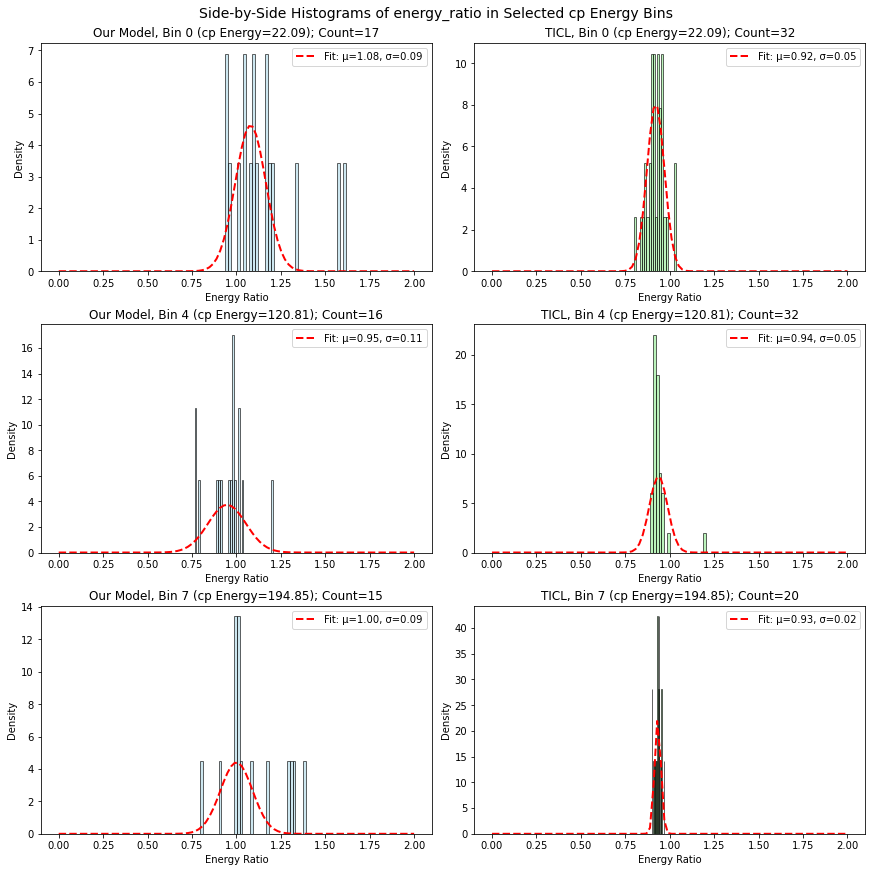

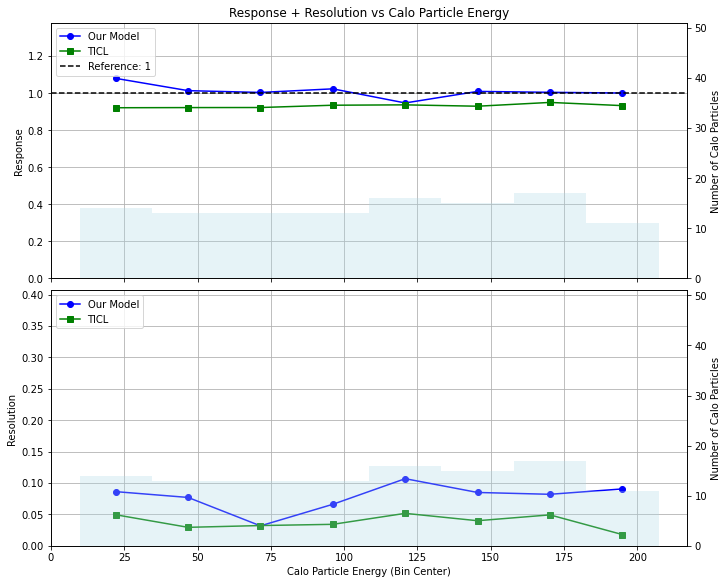

In [11]:
# iteration 3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ====================================================
# 1. Preprocessing and Association Selection for Calo Particles
# ====================================================
def process_cp_dataframe(df):
    """
    Convert relevant columns to numeric, then for each calo particle (identified by event_index and cp_id):
      - Group the data and take the first cp_energy value (assumed constant)
      - Compute the minimum sim_to_reco_score (i.e. best association)
      - Also take the energy_ratio from the best-associated trackster.
    Only keep those calo particles for which the minimum sim_to_reco_score < 0.2.
    """
    # Convert columns to numeric.
    for col in ['cp_id', 'sim_to_reco_score', 'reco_to_sim_score', 'cp_energy', 'energy_ratio']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Keep only rows with a sim_to_reco_score < 0.2
    df_cp = df[(df['sim_to_reco_score'] < 0.2) & (df['reco_to_sim_score'] < 0.2)].copy()
    
    # For each calo particle (cp_id per event) keep the row with the smallest sim_to_reco_score.
    df_cp = (df_cp.groupby(['event_index', 'cp_id'], as_index=False)
             .apply(lambda g: g.loc[g['sim_to_reco_score'].idxmin()])
             .reset_index(drop=True))
    return df_cp

# Process both dataframes
df_CL_cp   = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)

# ====================================================
# 2. Binning by Calo Particle Energy (cp_energy)
# ====================================================
n_bins = 8
# Determine energy bins from the CL model (you can change this if needed)
min_energy = df_CL_cp['cp_energy'].min()
max_energy = df_CL_cp['cp_energy'].max()
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

# Assign each calo particle to an energy bin based on cp_energy.
df_CL_cp['energy_bin']   = pd.cut(df_CL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ====================================================
# 3. Gaussian Fit in Each Energy Bin & Count Aggregation
# ====================================================
def fit_bins(df, n_bins):
    """
    For each energy bin, take the energy_ratio values from the processed calo particles,
    fit a Gaussian (if data exists), and record the fitted mean (response) and sigma (resolution).
    Also record the number of calo particles in each bin.
    
    Only considers energy_ratio values between 0 and 2.
    """
    fitted_mean = []
    fitted_sigma = []
    counts = []  # Number of calo particles in the bin.

    for b in range(n_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        bin_data = bin_data[(bin_data >= 0.75) & (bin_data <= 1.25)]  # Filter to 0 ≤ x ≤ 2
        counts.append(len(bin_data))
        
        if len(bin_data) > 0:
            mu, sigma = norm.fit(bin_data)
        else:
            mu, sigma = np.nan, np.nan  # Assign NaN if no valid data

        fitted_mean.append(mu)
        fitted_sigma.append(sigma)

    return np.array(fitted_mean), np.array(fitted_sigma), np.array(counts)

fitted_mean_CL, fitted_sigma_CL, counts_CL     = fit_bins(df_CL_cp, n_bins)
fitted_mean_TICL, fitted_sigma_TICL, counts_TICL = fit_bins(df_TICL_cp, n_bins)

# ====================================================
# 4. Plot Side-by-Side Histograms for Selected Bins (First, Middle, Last)
# ====================================================
selected_bins = [0, n_bins // 2, n_bins - 1]
n_sel = len(selected_bins)
fig_hist, axs = plt.subplots(n_sel, 2, figsize=(12, 4 * n_sel), constrained_layout=True)
xlim_range = (0, 2)  # fixed x-axis

for i, b in enumerate(selected_bins):
    # For df_CL histogram:
    data_CL = df_CL_cp.loc[df_CL_cp['energy_bin'] == b, 'energy_ratio'].dropna()
    ax_left = axs[i, 0] if n_sel > 1 else axs[0]
    n_CL, bins_CL, _ = ax_left.hist(data_CL, bins=40, density=True,
                                    color='lightblue', alpha=0.6, edgecolor='k')
    #ax_left.set_xlim(xlim_range)
    if len(data_CL) > 0:
        mu_CL = fitted_mean_CL[b]
        sigma_CL = fitted_sigma_CL[b]
        x_fit = np.linspace(xlim_range[0], xlim_range[1], 100)
        p_CL = norm.pdf(x_fit, mu_CL, sigma_CL)
        ax_left.plot(x_fit, p_CL, 'r--', linewidth=2,
                     label=f'Fit: μ={mu_CL:.2f}, σ={sigma_CL:.2f}')
    ax_left.set_title(f'Our Model, Bin {b} (cp Energy={bin_centers[b]:.2f}); Count={len(data_CL)}')
    ax_left.set_xlabel('Energy Ratio')
    ax_left.set_ylabel('Density')
    ax_left.legend(fontsize=10)
    
    # For df_TICL histogram:
    data_TICL = df_TICL_cp.loc[df_TICL_cp['energy_bin'] == b, 'energy_ratio'].dropna()
    ax_right = axs[i, 1] if n_sel > 1 else axs[1]
    n_TICL, bins_TICL, _ = ax_right.hist(data_TICL, bins=20, density=True,
                                          color='lightgreen', alpha=0.6, edgecolor='k')
    #ax_right.set_xlim(xlim_range)
    if len(data_TICL) > 0:
        mu_TICL = fitted_mean_TICL[b]
        sigma_TICL = fitted_sigma_TICL[b]
        x_fit = np.linspace(xlim_range[0], xlim_range[1], 100)
        p_TICL = norm.pdf(x_fit, mu_TICL, sigma_TICL)
        ax_right.plot(x_fit, p_TICL, 'r--', linewidth=2,
                      label=f'Fit: μ={mu_TICL:.2f}, σ={sigma_TICL:.2f}')
    ax_right.set_title(f'TICL, Bin {b} (cp Energy={bin_centers[b]:.2f}); Count={len(data_TICL)}')
    ax_right.set_xlabel('Energy Ratio')
    ax_right.set_ylabel('Density')
    ax_right.legend(fontsize=10)

plt.suptitle('Side-by-Side Histograms of energy_ratio in Selected cp Energy Bins', fontsize=14)
plt.show()

# ====================================================
# 5. Plot Response and Resolution vs. cp Energy Bin Centers
#     (with the df_CL counts as a background histogram)
# ====================================================
bar_width = energy_bins[1] - energy_bins[0]

fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

# Plot Response (fitted mean) vs cp_energy bin centers.
ax_resp.plot(bin_centers, fitted_mean_CL, marker='o', linestyle='-', color='blue', label='Our Model')
ax_resp.plot(bin_centers, fitted_mean_TICL, marker='s', linestyle='-', color='green', label='TICL')
ax_resp.axhline(1, color='k', linestyle='--', label='Reference: 1')
ax_resp.set_ylabel('Response')
ax_resp.set_title('Response + Resolution vs Calo Particle Energy', fontsize=12)
ax_resp.grid(True)
ax_resp.legend(loc='upper left', fontsize=10)
ax_resp.set_ylim(0, max(fitted_mean_CL.max(), fitted_mean_TICL.max()) + 0.3)

# Twin axis to display the number of calo particles (from df_CL) as background.
ax_resp2 = ax_resp.twinx()
ax_resp2.bar(bin_centers, counts_CL, width=bar_width, color='lightblue', alpha=0.3)
ax_resp2.set_ylabel('Number of Calo Particles')
ax_resp2.set_ylim(0, 3*counts_CL.max())

# Plot Resolution (fitted sigma) vs cp_energy bin centers.
ax_res.plot(bin_centers, fitted_sigma_CL, marker='o', linestyle='-', color='blue', label='Our Model')
ax_res.plot(bin_centers, fitted_sigma_TICL, marker='s', linestyle='-', color='green', label='TICL')
ax_res.set_xlabel('Calo Particle Energy (Bin Center)')
ax_res.set_ylabel('Resolution')
ax_res.grid(True)
ax_res.legend(loc='upper left', fontsize=10)
ax_res.set_ylim(0, max(fitted_sigma_CL.max(), fitted_sigma_TICL.max()) + 0.3)

# Twin axis for df_CL counts.
ax_res2 = ax_res.twinx()
ax_res2.bar(bin_centers, counts_CL, width=bar_width, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Number of Calo Particles')
ax_res2.set_ylim(0, 3*counts_CL.max())

plt.show()

# Additional Validation steps

The following code blocks are validation steps or sanity checks to see whether our methods give sensible results that we expect.

#### 1. Checking performance of model inference on single caloparticle events in the test data (single caloparticle events in the training data were skipped)

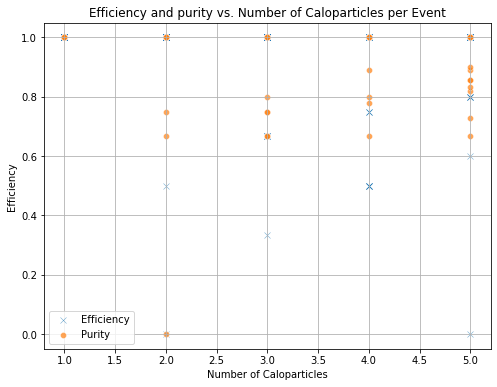

In [12]:
import seaborn as sns

def validate_single(df):
    results = []
    
    # ----- Efficiency Calculation -----
    cp_valid = df.dropna(subset=['cp_id']).copy()
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    for event_index, group in cp_valid.groupby('event_index'):
        cp_grouped = group.groupby('cp_id')
        cp_associated = cp_grouped['sim_to_reco_score'].min() < 0.2
        num_associated_cp = cp_associated.sum()
        total_cp = cp_associated.count()
        efficiency = num_associated_cp / total_cp if total_cp > 0 else 0
        
        tst_grouped = group.groupby('trackster_id')
        tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
        num_associated_tst = tst_associated.sum()
        total_tst = tst_associated.count()
        purity = num_associated_tst / total_tst if total_tst > 0 else 0
    
        results.append({
            'event_index': event_index,
            'efficiency': efficiency,
            'purity': purity,
            'num_caloparticles': total_cp
        })
        
    
    # Return the results at the end of the function
    return results

# Now you can use the function and plot the results
event_metrics = list(validate_single(df))
event_metrics_df = pd.DataFrame(event_metrics)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=event_metrics_df, x='num_caloparticles', y='efficiency', alpha=0.7, marker='x',label='Efficiency')
sns.scatterplot(data=event_metrics_df, x='num_caloparticles', y='purity', alpha=0.7, marker='o', label='Purity')
plt.title('Efficiency and purity vs. Number of Caloparticles per Event')
plt.xlabel('Number of Caloparticles')
plt.ylabel('Efficiency')
plt.grid(True)
plt.show()
# plot average efficiency?

#### 2. Plotting longitudinal energy profiles of both simulated (caloparticle) and reconstructed (trackster) showers, coloured so that caloparticles and tracksters that are best associated according to their sim_to_reco score are the same colour.
Currently the plots are showing TICL tracksters. For model tracksters replace 'Track_ind' passed in as a argument of the $\textit{calculate_all_event_profile_data}$ function with 'recon_ind'.

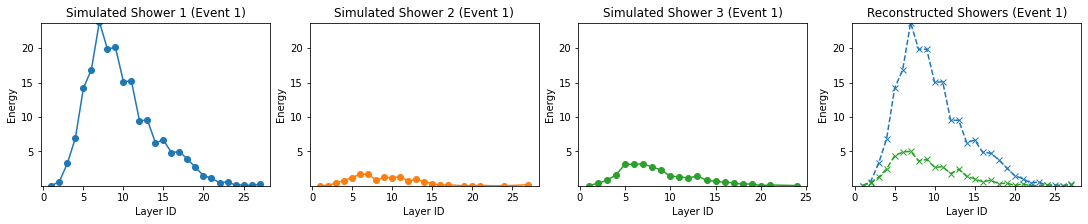

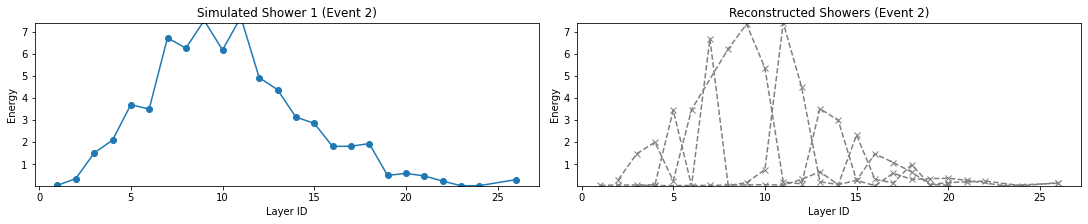

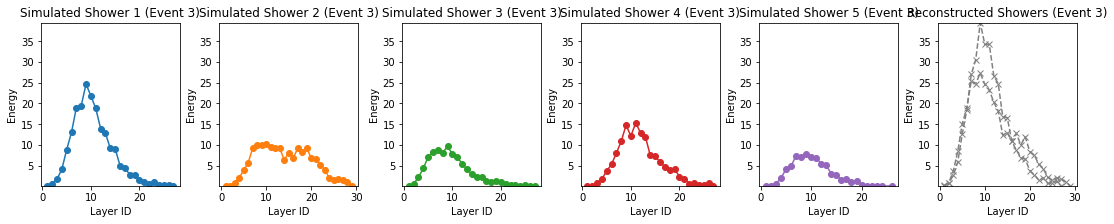

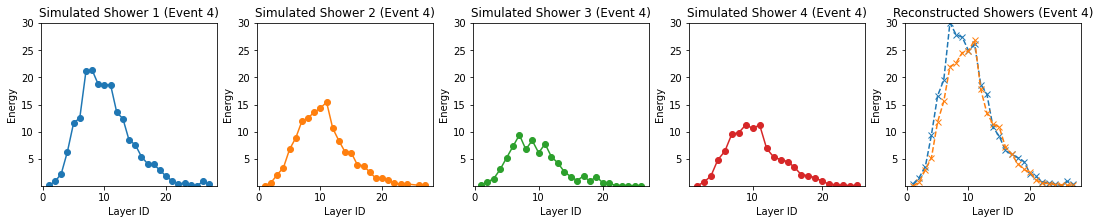

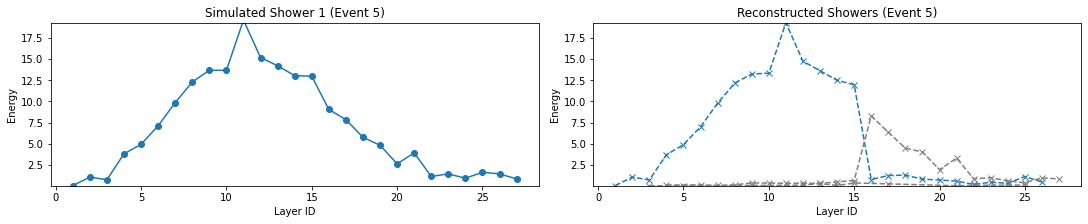

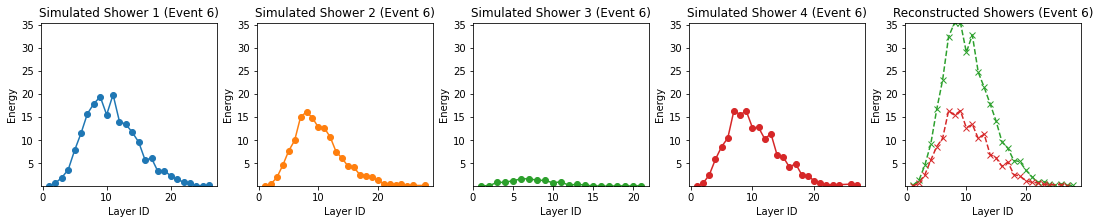

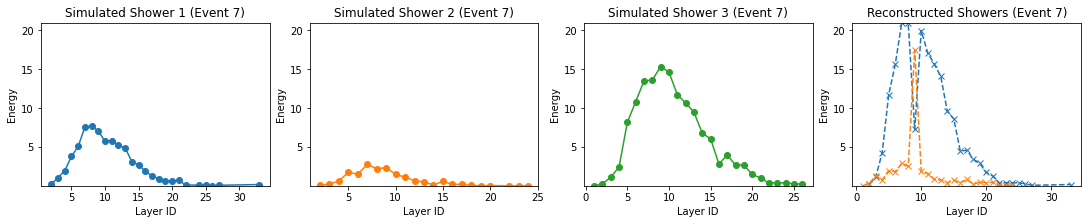

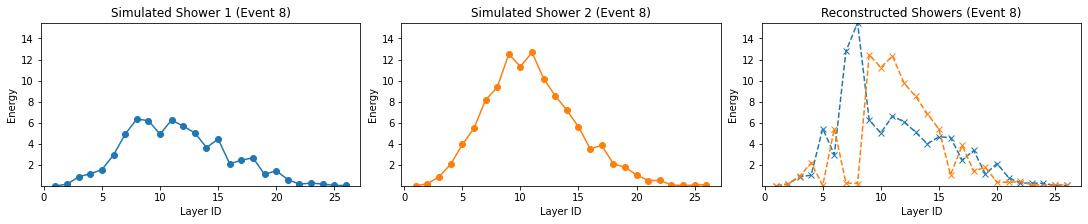

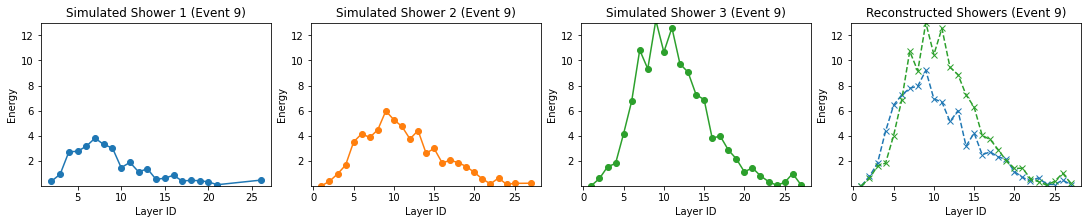

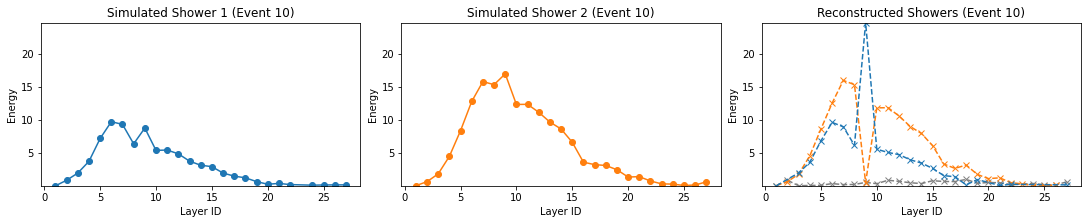

In [13]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters;3']['cluster_layer_id'].array()

def calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, multi, num_events=10):
    # Define unique colors for caloparticles
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Loop over all events
    for event_index in range(num_events):
        # Get data for the current event
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_layer_id = layer[event_index]
        event_multi = multi[event_index]

        # Initialize lists for profiles and associations
        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}  # To store caloparticle-trackster associations

        # Simulated particle shower
        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)

        # Reconstructed particle shower
        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)

        # Calculate sim_to_reco score and determine associations


        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            # Loop over all Tracksters
            best_score = float('inf')
            best_tst_idx = None
            
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                sim_to_reco_score = calculate_sim_to_reco_score(caloparticle, event_energies, trackster, Calo_multi)
                if sim_to_reco_score < 0.2 and sim_to_reco_score < best_score:
                    best_score = sim_to_reco_score
                    best_tst_idx = trackster_idx
                    
            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx
        
        
        # Determine energy range from reconstructed showers for consistent y-axis
        min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
        max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
    
    
        # Plot simulated profiles
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'], marker='o', linestyle='-', color=colors[idx % len(colors)])
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1} (Event {event_index + 1})')
            ax.set_xlabel('Layer ID')
            ax.set_ylabel('Energy')

        # Plot all reconstructed profiles in a single plot
        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            # Determine color based on association
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            color = colors[associated_cp[0] % len(colors)] if associated_cp else 'gray'
            ax.plot(profile['layer_id'], profile['energy'], marker='x', linestyle='--', color=color)
        ax.set_ylim(min_energy, max_energy)
        ax.set_title(f'Reconstructed Showers (Event {event_index + 1})')
        ax.set_xlabel('Layer ID')
        ax.set_ylabel('Energy')

        # Show the plots
        plt.show()

events = calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, GT_mult)

#### 3. Demonstrating discrepancies in the total number of LCs across all caloparticles or tracksters between the simtrackstersCP and tracksters branch from the root file

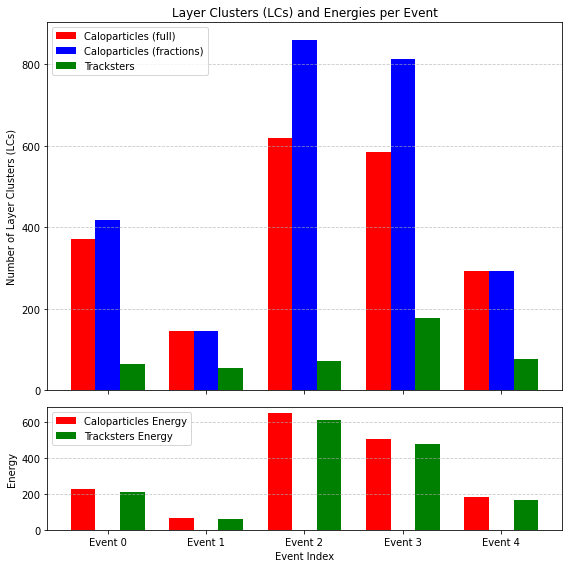

In [18]:
# Demonstration of discrepancies in the total number of LCs in each simulation/reconstruction

sum_lc_values = [] 
sum_cp_values = []  
sum_ts_values = [] 
sum_lc_energy_values = []
sum_ts_energy_values = []

for event_index in range(0, 5):
    flat_GT_ind = ak.flatten(GT_ind[event_index])
    flat_Track_ind = ak.flatten(Track_ind[event_index])
    sum_lc = len(energies[event_index])
    sum_cp = len(flat_GT_ind)
    sum_ts = len(flat_Track_ind)
    sum_lc_energy = sum(energies[event_index])
    sum_ts_energy = sum(energies[event_index][flat_Track_ind])

    sum_lc_values.append(sum_lc)
    sum_cp_values.append(sum_cp)
    sum_ts_values.append(sum_ts)
    sum_lc_energy_values.append(sum_lc_energy)
    sum_ts_energy_values.append(sum_ts_energy)

events = range(0, 5)  # Event indices
bar_width = 0.25
x_indices = np.arange(len(events))


# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Top plot: Discrepancies in total number of LCs
axes[0].bar(x_indices - bar_width, sum_lc_values, width=bar_width, label='Caloparticles (full)', color='r')
axes[0].bar(x_indices, sum_cp_values, width=bar_width, label='Caloparticles (fractions)', color='b')
axes[0].bar(x_indices + bar_width, sum_ts_values, width=bar_width, label='Tracksters', color='g')
axes[0].set_ylabel('Number of Layer Clusters (LCs)')
axes[0].set_title('Layer Clusters (LCs) and Energies per Event')
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Bottom plot: Energies only
axes[1].bar(
    x_indices - bar_width, 
    sum_lc_energy_values, 
    width=bar_width, 
    label='Caloparticles Energy', 
    color='r'
)
axes[1].bar(
    x_indices + bar_width, 
    sum_ts_energy_values, 
    width=bar_width, 
    label='Tracksters Energy', 
    color='g'
)

axes[1].set_ylabel('Energy')
axes[1].set_xlabel('Event Index')
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout and show the plots
plt.xticks(x_indices, [f'Event {e}' for e in events])
plt.tight_layout()
plt.show()


The LCs 'lost' when going from caloparticle to TICL trackster is most likely an energy mask.

#### 4. Distribution of model tracksters according to how many LCs it constitutes

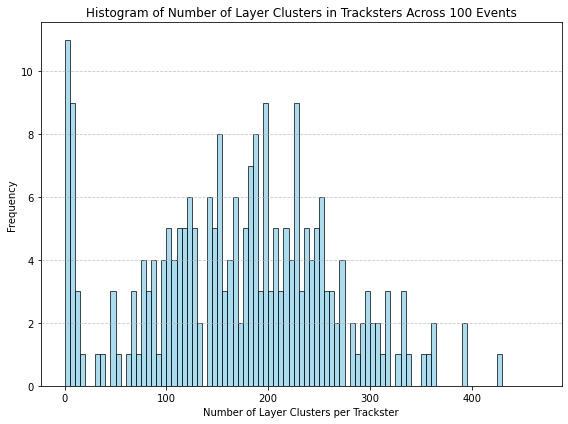

In [19]:
# cause for cleaning?

num_lcs = []
for event_index in range(0, 100):
    tracksters = recon_ind[event_index]
    event_energies = energies[event_index]
    for trackster in tracksters:
        num_lc = len(trackster)
        trackster_energy = np.sum([event_energies[lc] for lc in trackster])
        num_lcs.append(num_lc)
    
    # Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(num_lcs, bins=np.arange(0,max(num_lcs),5), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Number of Layer Clusters in Tracksters Across 100 Events')
plt.xlabel('Number of Layer Clusters per Trackster')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()